based on https://jhat.readthedocs.io/en/latest/examples/plot_b_nircam.html

In [1]:
%matplotlib inline


# JWST NIRCAM

Aligning JWST/NIRCAM images with JHAT.


An example NIRCam Dataset is downloaded, and then a series of
alignment methods are used. For more information on the
key parameters used for alignment see 
`params:Useful Parameters`.

In [2]:
import sys,os,glob
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.nddata import extract_array
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.visualization import (simple_norm,LinearStretch)
from astroquery.gaia import Gaia

from scipy.ndimage import binary_dilation
from copy import deepcopy

import jhat
from jhat import jwst_photclass,st_wcs_align

from nbutils import xmatch_common



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


## Relative Alignment

**Download some Data**

For this example we download 2 JWST NIRCam images from MAST. They're
the same field but different filters. Note that 
the code will also work for level 3 data images.



In [4]:
obs_table1 = Observations.query_criteria(obs_id='jw02107-o041_t019_nircam_clear-f200w')
data_products_by_obs = Observations.get_product_list(obs_table1)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
data_products_by_obs = data_products_by_obs[data_products_by_obs['obs_id']=='jw02107041001_02101_00001_nrcb1']

In [18]:
data_products_by_obs

<Table masked=True length=1>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str4            str5       ...    str6       int64      str5 
-------- -------------- ---------------- ... ---------- ----------- -------
87617603           JWST            image ...     PUBLIC           2   F200W

In [19]:
Observations.download_products(data_products_by_obs,extension='fits')

<Table length=1>
                                         Local Path                                          ...
                                           str92                                             ...
-------------------------------------------------------------------------------------------- ...
./mastDownload/JWST/jw02107041001_02101_00001_nrcb1/jw02107041001_02101_00001_nrcb1_cal.fits ...

In [20]:
obs_table2 = Observations.query_criteria(obs_id='jw02107-o041_t019_nircam_clear-f360m')
data_products_by_obs = Observations.get_product_list(obs_table2)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
data_products_by_obs = data_products_by_obs[data_products_by_obs['obs_id']=='jw02107041001_02101_00001_nrcblong']

In [21]:
data_products_by_obs

<Table masked=True length=1>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str4            str5       ...    str6       int64      str5 
-------- -------------- ---------------- ... ---------- ----------- -------
87617252           JWST            image ...     PUBLIC           2   F360M

In [22]:
Observations.download_products(data_products_by_obs,extension='fits')

<Table length=1>
                                            Local Path                                             ...
                                              str98                                                ...
-------------------------------------------------------------------------------------------------- ...
./mastDownload/JWST/jw02107041001_02101_00001_nrcblong/jw02107041001_02101_00001_nrcblong_cal.fits ...

**Create a Photometric Catalog for Relative Alignment**

We choose one of the images to be the reference image, and then 
create a catalog that we will use to align the other image.



In [60]:
ref_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_cal.fits')[0]

In [61]:
jwst_phot = jwst_photclass()
jwst_phot.run_phot(imagename=ref_image,photfilename='auto',overwrite=True,ee_radius=80,use_dq=True)
ref_catname = ref_image.replace('.fits','.phot.txt') # the default
refcat = Table.read(ref_catname,format='ascii')
print(refcat)

0 jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_cal.phot.txt


2024-09-26 13:44:08,148 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-26 13:44:08,475 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-26 13:44:08,495 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-26 13:44:08,498 - stpipe - INFO - Instrument: NIRCAM
2024-09-26 13:44:08,499 - stpipe - INFO - Detector: NRCA4
2024-09-26 13:44:08,499 - stpipe - INFO - Filter: F090W
2024-09-26 13:44:08,500 - stpipe - INFO - Pupil: CLEAR
2024-09-26 13:44:08,502 - stpipe - INFO - Subarray: FULL
2024-09-26 13:44:08,551 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.36200000000000004
aper_sum_7.5px annulus_median_7.5px aper_bkg_7.5px ...   x_idl      y_idl   
-------------- -------------------- -------------- ... ---------- ----------
    217.391903              0.74648     131.211238 ... -26.505511 -31.343517
     161.09213             0.895343     157.377412 ...  -4.488737 -31.511663
   1348.122958             1.945721     342.005957 ...  10.300244 -31.600683
    434.170569             2.055243     361.257068 ...  11.095951 -31.573687
   2133.167646             4.606422     809.686251 ...  14.891911 -31.506553
    1683.51849             3.081981     541.730124 ...  20.102072 -31.548196
   1268.387746             4.799665     843.653313 ...  21.394131  -31.62952
    498.478451             2.399218     421.718556 ...  22.170991  -31.55809
   1791.849782               5.4892     964.855184 ...  28.871605 -31.576615
   1149.240204             1.090143     191.618141 ...   -28.9046 -31.336692
           ...                  ...            ... 

**Align the second image**

The plots outputted here show the various steps used by jhat to
determine the true matching sources in the image, and the
subsequent correction needed for optimal alignment.



In [63]:
# align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_cal.fits')[0]
align_image = glob.glob('jwstred_temp_gaia/jw01334001001_04101_00001_nrca4_cal.fits')[0]

0 ./jwstred_temp_gaia/jw01334001001_04101_00001_nrca4.phot.txt
Using DQ extension!!


2024-09-26 13:46:45,446 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-26 13:46:45,806 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-26 13:46:45,821 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-26 13:46:45,823 - stpipe - INFO - Instrument: NIRCAM
2024-09-26 13:46:45,824 - stpipe - INFO - Detector: NRCA4
2024-09-26 13:46:45,825 - stpipe - INFO - Filter: F150W
2024-09-26 13:46:45,826 - stpipe - INFO - Pupil: CLEAR
2024-09-26 13:46:45,827 - stpipe - INFO - Subarray: FULL
2024-09-26 13:46:45,868 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.2172
dmag 0.1
sharpness 0.9
roundness1 0.7
mag 21
x 2008
y 2008
reffile_d2d 0.15
*** Note: close plot to continue!


<IPython.core.display.Javascript object>


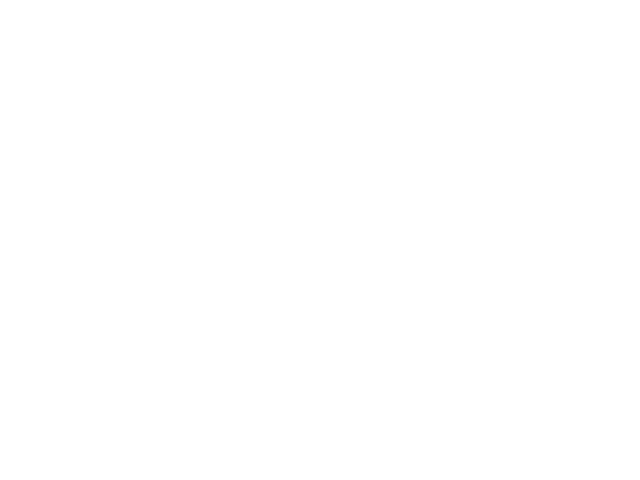

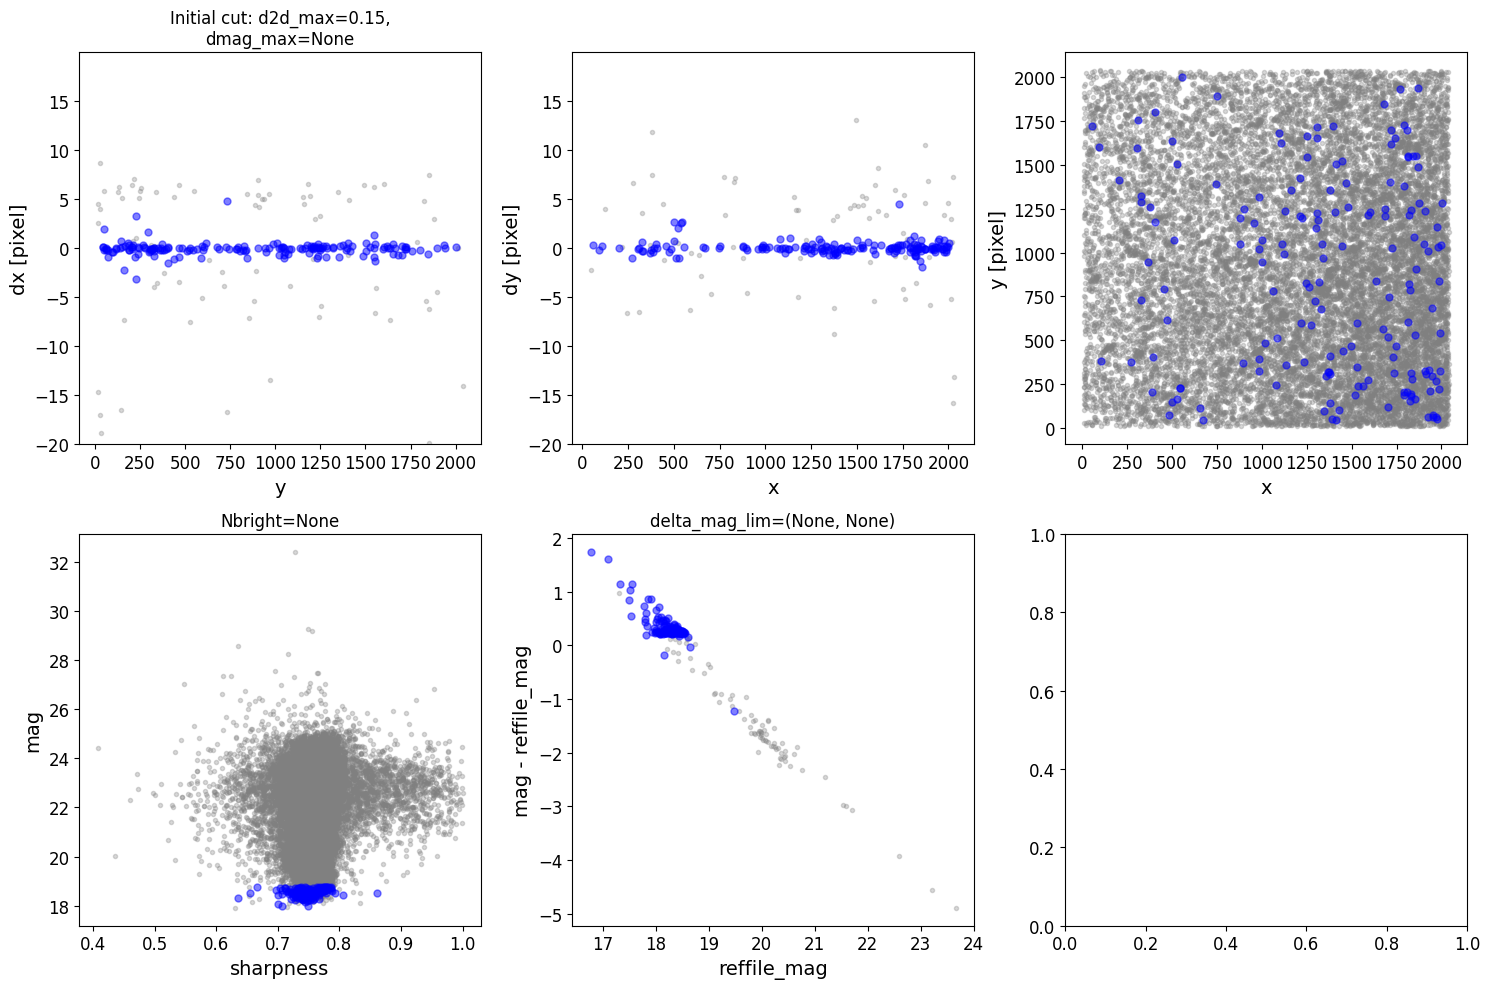

   slope  intercept  maxval  index  d_bestguess  fwhm  multimax
0.000391       -0.4   114.0      4    -0.050005   1.6     False
d_rot_tmp 0.7499946592293825
Keeping 145 out of 145, skippin 0 because of null values in columns d_rot_tmp
median: 0.036844
75.000000 percentile cut: max residual for cut: 0.355323
__tmp_residuals 0.3553232443509177
median: 0.054773
i:00 mean:0.054773(0.016732) stdev:0.173073(0.011776) X2norm:1.00 Nchanged:0 Ngood:108 Nclip:37

mean: 0.059996
i:01 mean:0.059996(0.020174) stdev:0.227352(0.014209) X2norm:1.00 Nchanged:20 Ngood:128 Nclip:17

mean: 0.059804
i:02 mean:0.059804(0.023153) stdev:0.270997(0.016312) X2norm:1.00 Nchanged:10 Ngood:138 Nclip:7

mean: 0.033925
i:03 mean:0.033925(0.025106) stdev:0.299173(0.017690) X2norm:1.00 Nchanged:5 Ngood:143 Nclip:2

mean: 0.022014
i:04 mean:0.022014(0.026151) stdev:0.313809(0.018427) X2norm:1.00 Nchanged:2 Ngood:145 Nclip:0

mean: 0.022014
i:05 mean:0.022014(0.026151) stdev:0.313809(0.018427) X2norm:1.00 Nchanged:0 Ngo

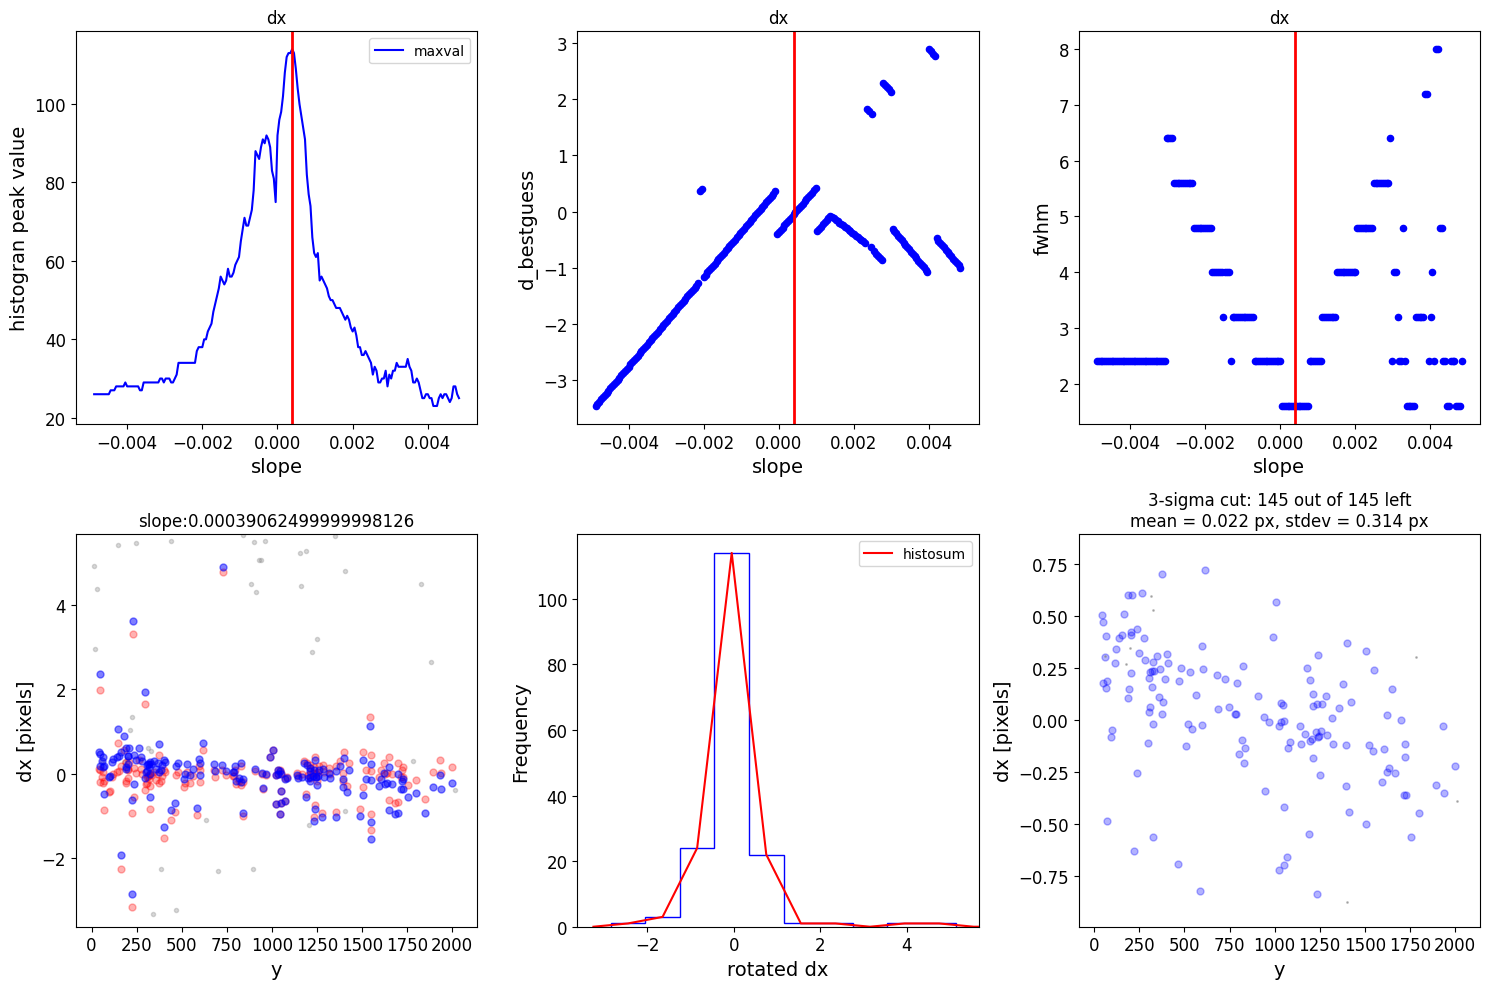

   slope  intercept  maxval  index  d_bestguess  fwhm  multimax
0.000146      -0.15   108.0      3    -0.042939   1.6     False
d_rot_tmp 0.7570610854132138
Keeping 136 out of 136, skippin 0 because of null values in columns d_rot_tmp
median: -0.095475
75.000000 percentile cut: max residual for cut: 0.333248
__tmp_residuals 0.33324760028206873
median: -0.090191
i:00 mean:-0.090191(0.016574) stdev:0.166570(0.011662) X2norm:1.00 Nchanged:0 Ngood:102 Nclip:34

mean: -0.105766
i:01 mean:-0.105766(0.020097) stdev:0.216452(0.014150) X2norm:1.00 Nchanged:15 Ngood:117 Nclip:19

mean: -0.117870
i:02 mean:-0.117870(0.022280) stdev:0.247093(0.015690) X2norm:1.00 Nchanged:7 Ngood:124 Nclip:12

mean: -0.123037
i:03 mean:-0.123037(0.024448) stdev:0.276594(0.017220) X2norm:1.00 Nchanged:5 Ngood:129 Nclip:7

mean: -0.093046
i:04 mean:-0.093046(0.027009) stdev:0.311478(0.019027) X2norm:1.00 Nchanged:5 Ngood:134 Nclip:2

mean: -0.080758
i:05 mean:-0.080758(0.027991) stdev:0.325228(0.019720) X2norm:1.00 

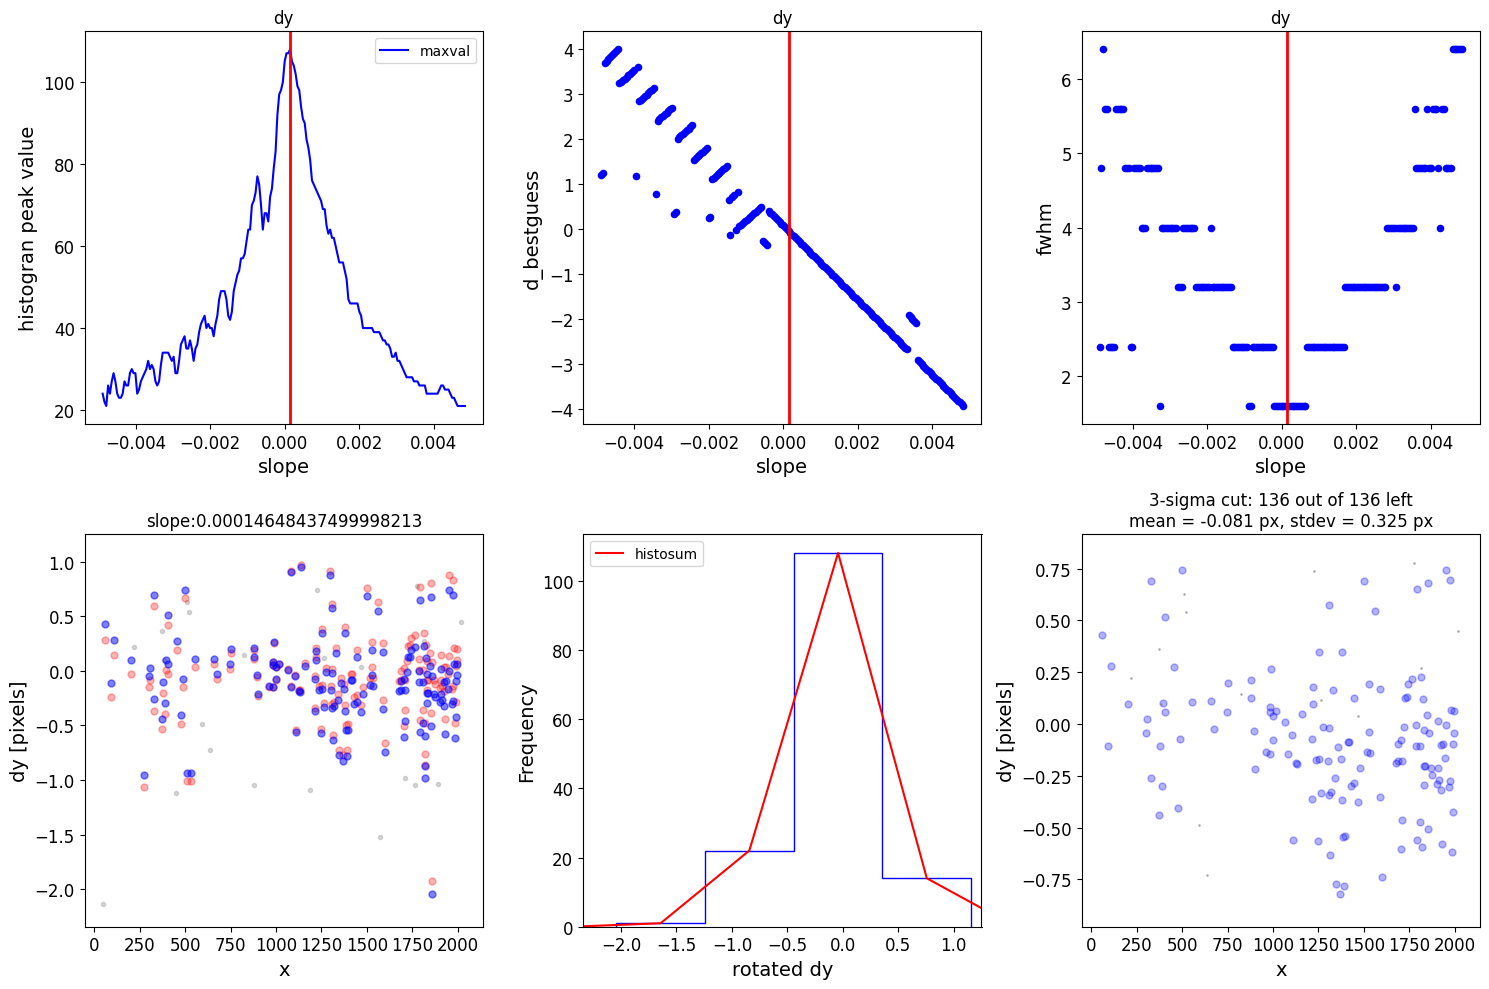

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-09-26 13:47:13,766 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2024-09-26 13:47:14,513 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01334001001_04101_00001_nrca4_cal.fits>],).
2024-09-26 13:47:14,519 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jwstred_temp_gaia/jw01334001001_04101_00001_nrca4_jhat.fits
  output_dir: ./jwstred_temp_gaia
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_

replacing SIP ./jwstred_temp_gaia/jw01334001001_04101_00001_nrca4_jhat.fits


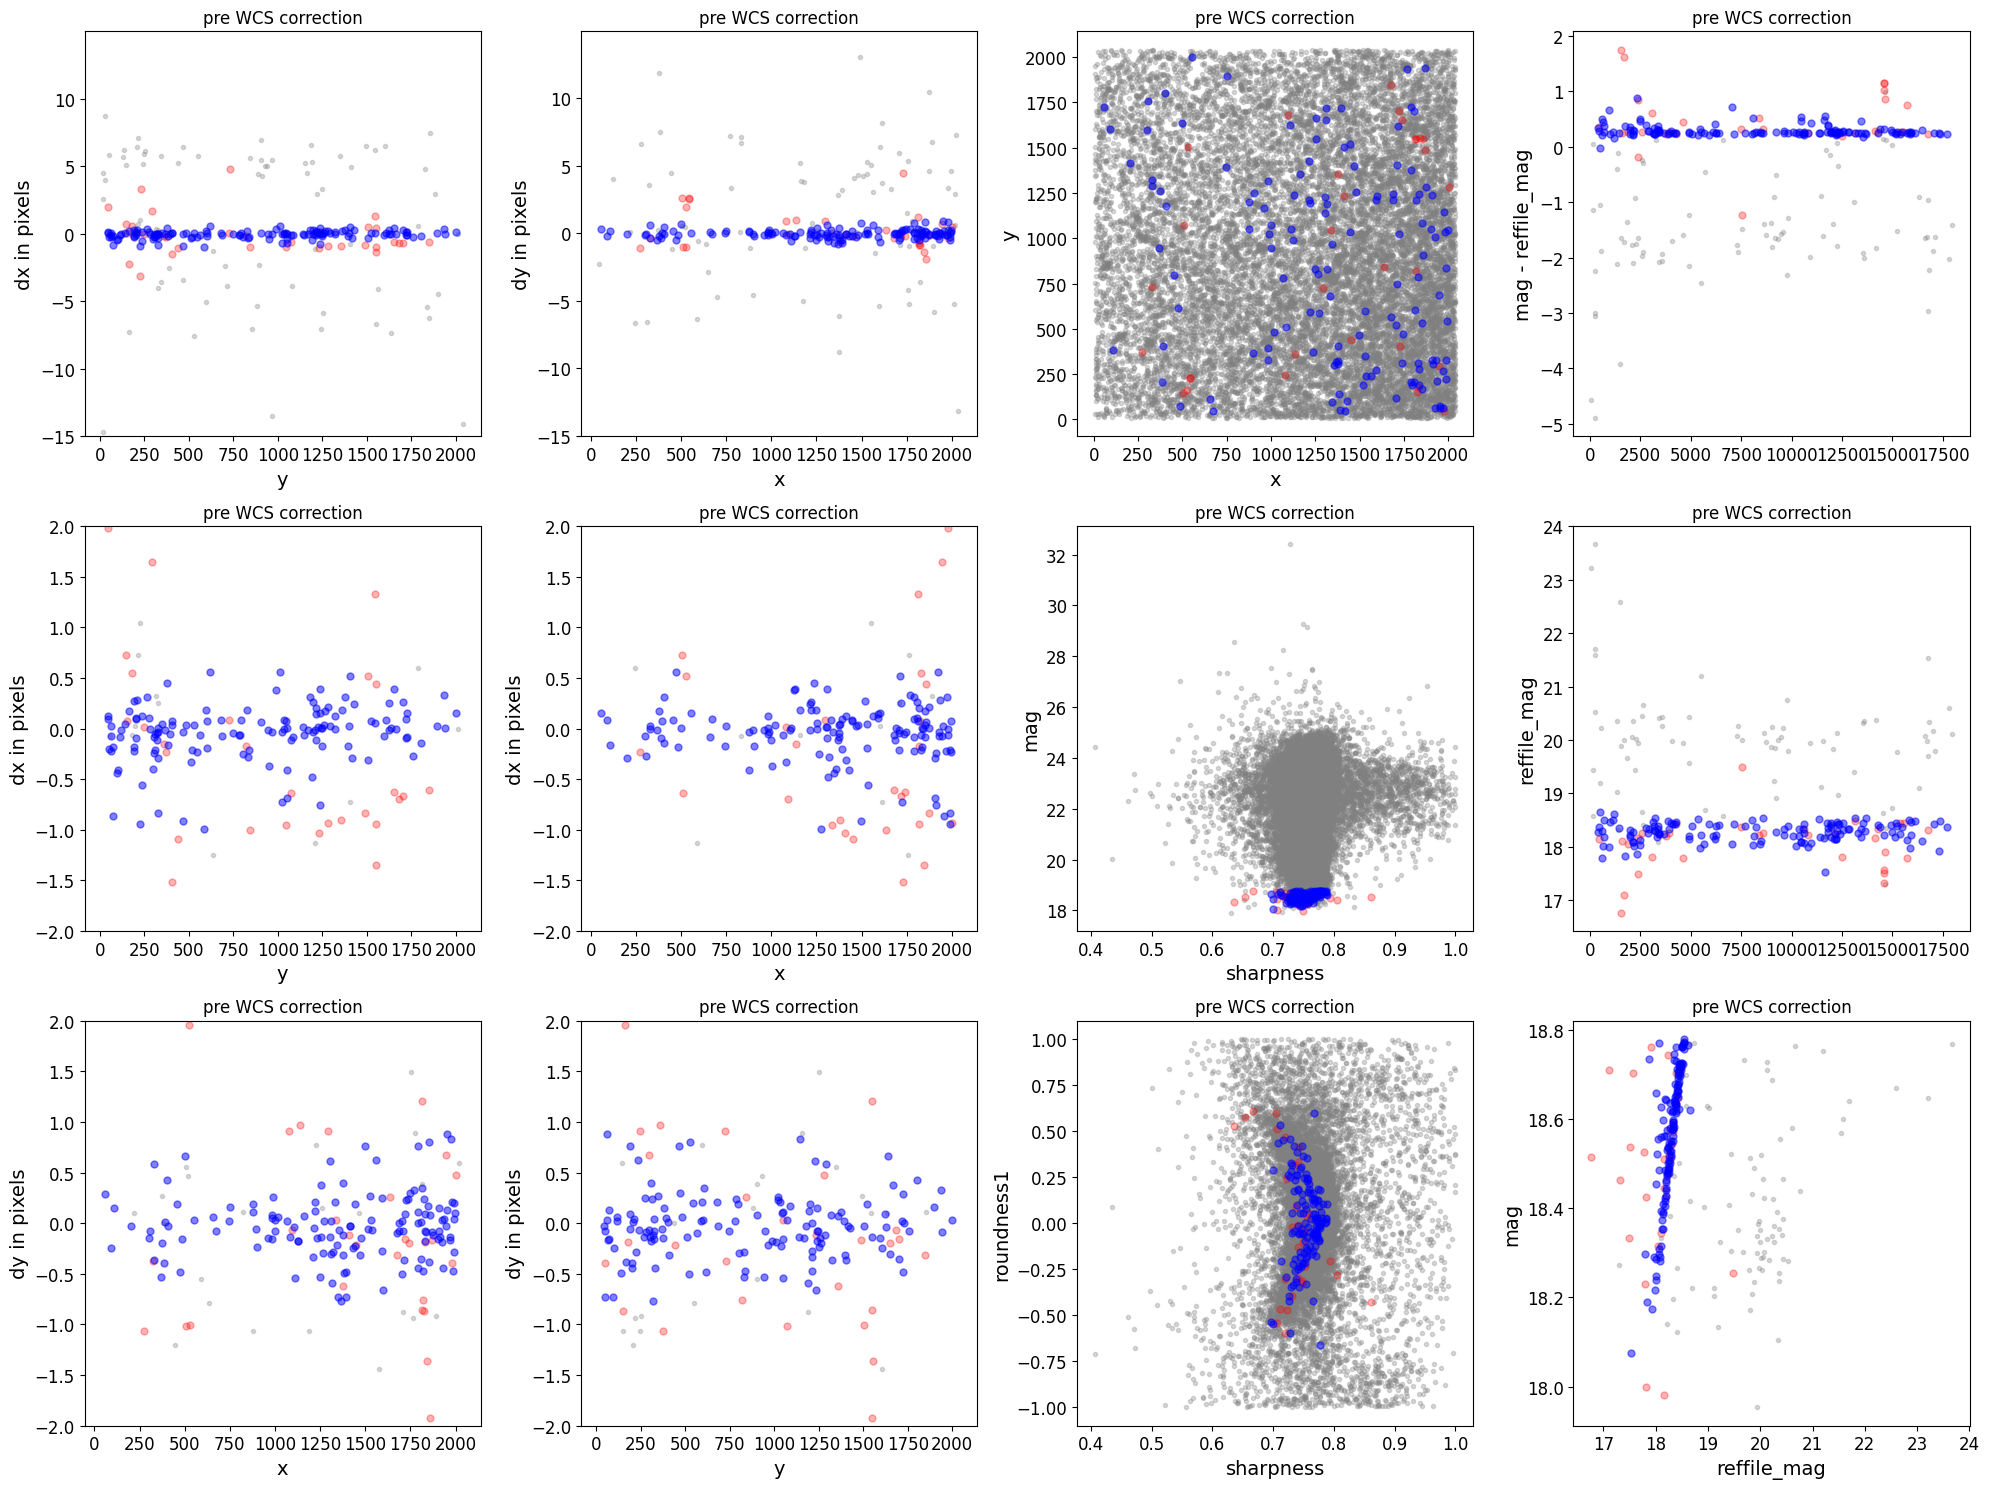

./jwstred_temp_gaia/jw01334001001_04101_00001_nrca4_jhat.fits


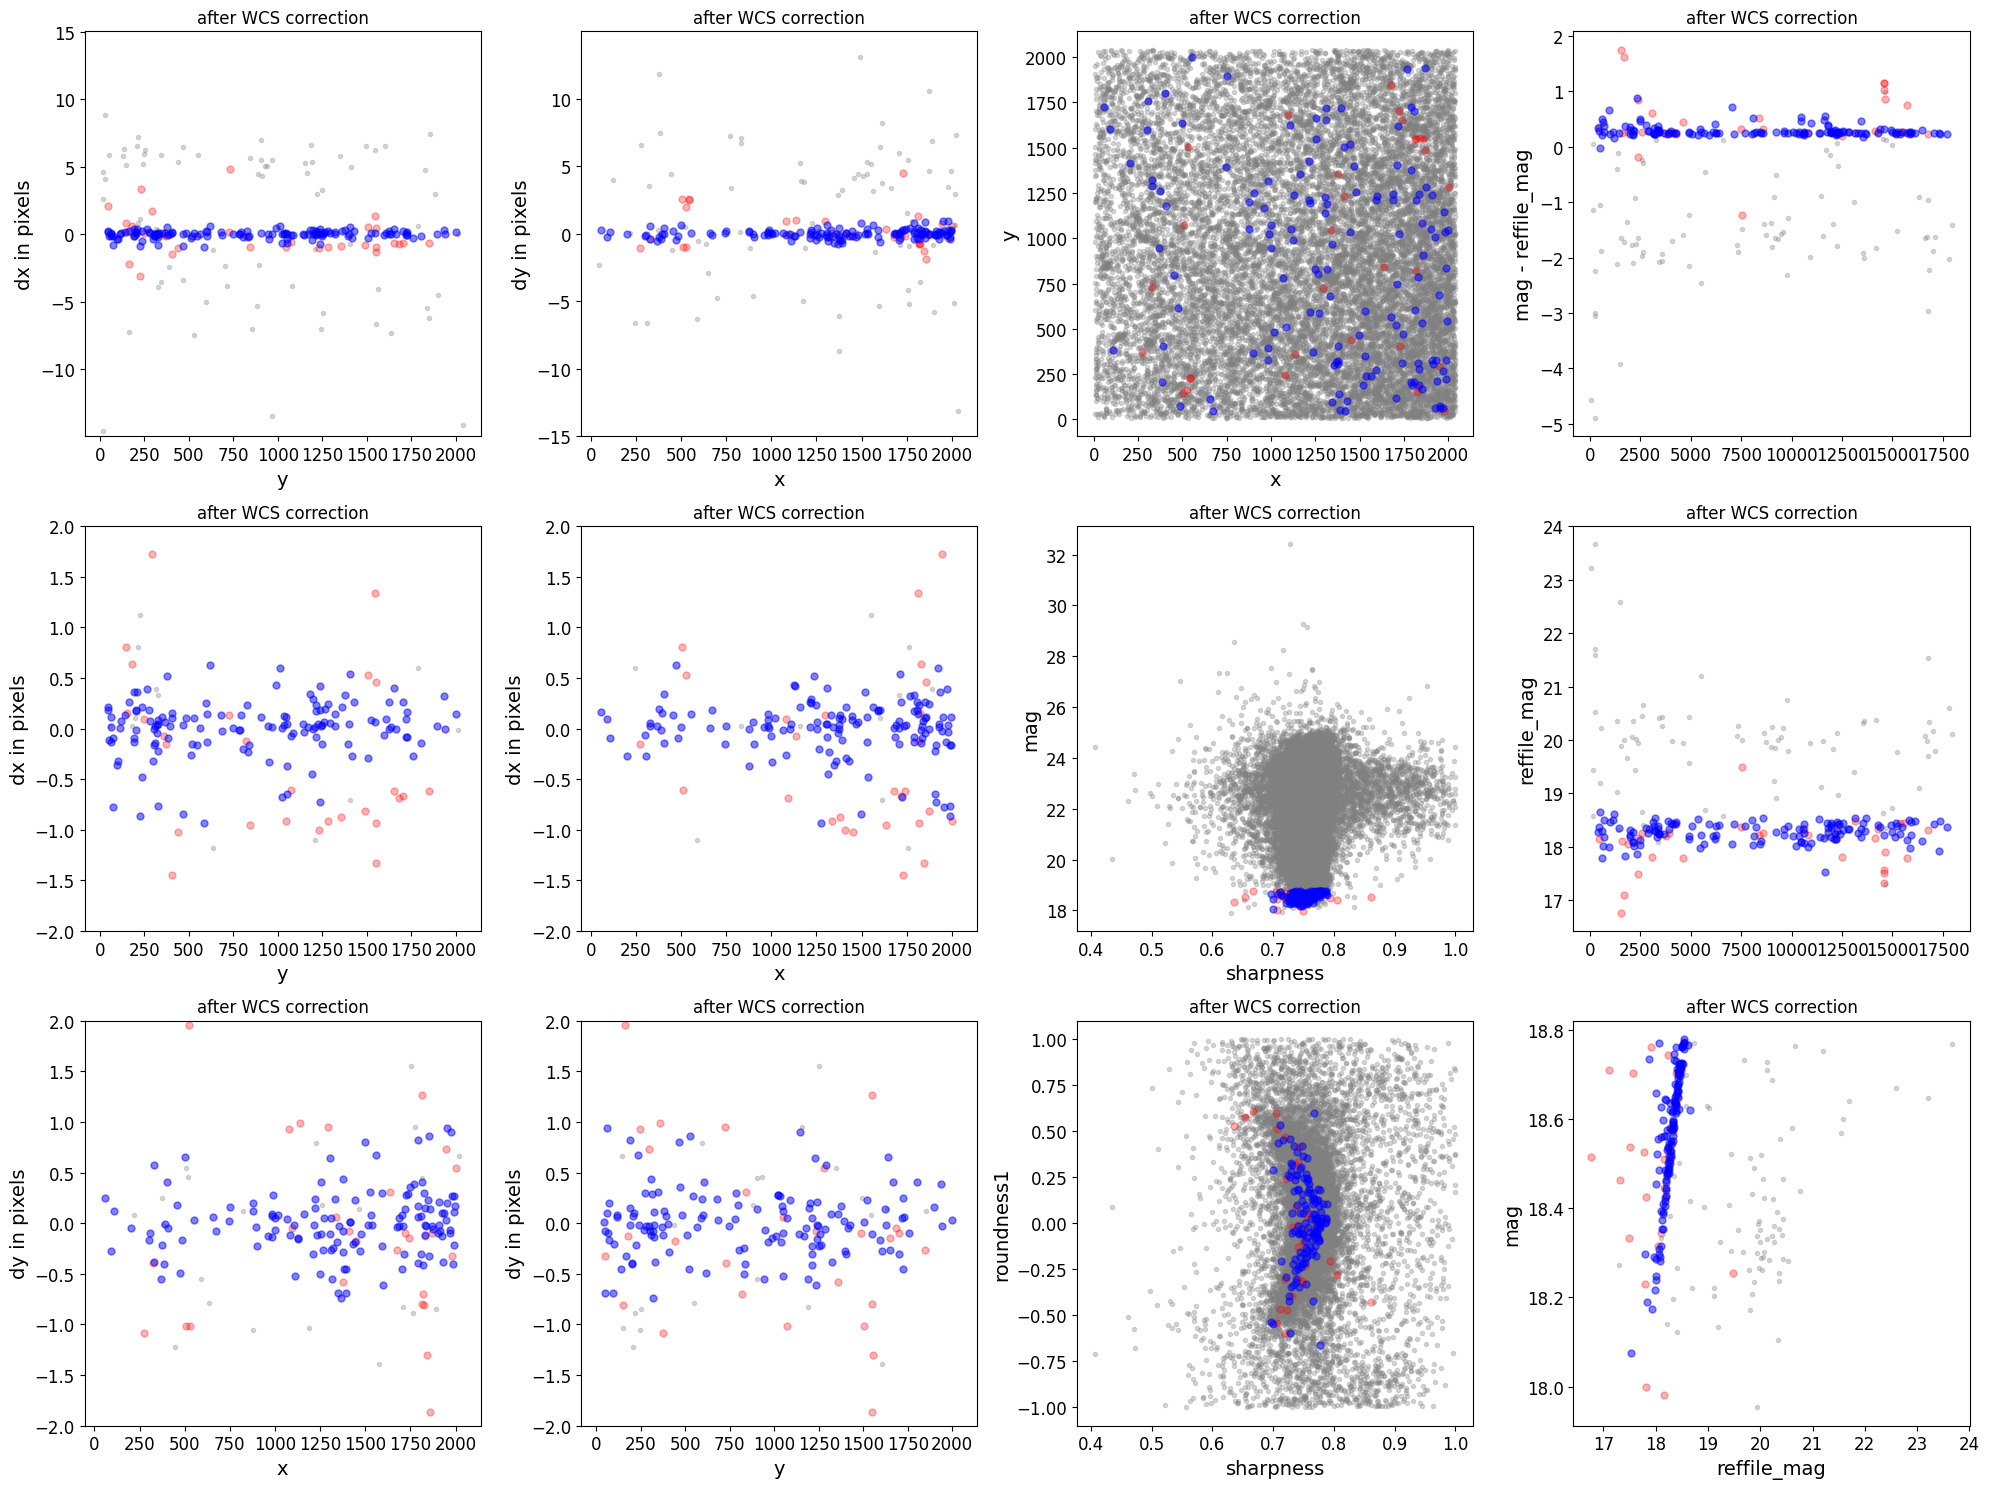

*** Note: close plots to continue!


0

In [66]:
wcs_align = st_wcs_align()


wcs_align.run_all(align_image,
          telescope='jwst',
          outsubdir='jwstred_temp_gaia',
          refcat_racol='ra',
          refcat_deccol='dec',
          refcat_magcol='mag',
          refcat_magerrcol='dmag',
          overwrite=True,
          d2d_max=.15,
          showplots=2,
          find_stars_threshold=5,
          refcatname=ref_catname,
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 5,
              dmag_max=0.1,
              Nbright=250,
              objmag_lim =(14,21),
              binsize_px = 0.8,
              use_dq = True)

## Align to Catalog

You can also align each image to the Gaia DR3 catalog, or you
could replace the catalog created in step one with your own
catalog of the field. 



In [21]:
# align_image = glob.glob('jwstred_temp_gaia/jw01783004002_02101_00004_nrcb2_cal.fits')[0] #short wavelength
# align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal.fits')[0] #long wavelength
align_image = glob.glob('jwstred_temp_gaia/jw01783004005_02101_00001_nrcalong_cal.fits')[0]
# align_image = glob.glob('jwstred_temp_gaia/jw01334-o001_t001_nircam_clear-f277w_i2d.fits')[0] #level3 file
# align_image = glob.glob('jwstred_temp_mosaic/jw02784002001_02101_00001_nrcb1_cal.fits')[0]
# align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits')[0]

In [8]:
# to plot regions in ds9
try:
    align_df = pd.read_csv(align_image.replace('.fits', '.phot_psf.txt'), sep = '\s+')
    np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), align_df[['x', 'y']].values, fmt='%s')
except:
    align_df = pd.read_csv(align_image.replace('_cal.fits', '.phot.txt'), sep = '\s+')
    np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), align_df[['x', 'y']].values, fmt='%s')    

In [9]:
_df = pd.read_csv('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal_region.txt', sep = '\s+', header = None)
_df[0], _df[1] = _df[0]+1, _df[1]+1
np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), _df.values, fmt='%s')

telescope set to jwst

### Doing photometry on jwstred_temp_gaia/jw01783004005_02101_00001_nrcalong_cal.fits
True ./jwstred_temp_gaia/jw01783004005_02101_00001_nrcalong.phot.txt
photometry catalog filename: ./jwstred_temp_gaia/jw01783004005_02101_00001_nrcalong.phot.txt
photcat ./jwstred_temp_gaia/jw01783004005_02101_00001_nrcalong.phot.txt already exists, but recreating it since overwrite=True
Instrument: NIRCAM, aperture:NRCA5_FULL
Applying Pixel Area Map
Finding stars --- Detector: NRCALONG, Filter: F277W
FWHM for the filter F277W: 1.444 px
Background and rms using MMMBackground and MADStdBackgroundRMS: 0.43223655223846436 0.25475173706274573


2024-10-10 21:55:06,780 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-10-10 21:55:06,958 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-10-10 21:55:06,969 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-10-10 21:55:06,970 - stpipe - INFO - Instrument: NIRCAM
2024-10-10 21:55:06,971 - stpipe - INFO - Detector: NRCALONG
2024-10-10 21:55:06,971 - stpipe - INFO - Filter: F277W
2024-10-10 21:55:06,972 - stpipe - INFO - Pupil: CLEAR
2024-10-10 21:55:06,972 - stpipe - INFO - Subarray: FULL



Number of sources found in the image: 18389
-------------------------------------



2024-10-10 21:55:07,000 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


radii:[2.311]pixels radius_sky_in:3.0859999656677246 radius_sky_out:5.238999843597412  radius_for_mag:[2.311]
Performing aperture photometry for radius r = 2.311000108718872 px
Time Elapsed: 13.998764806998224
18187 objects left after removing entries with NaNs in mag or dmag column
dmag 0.2172
SNR_min cut: 17939 objects left after removing entries dmag>0.2172 (SNR<5)
17939 out of 18187 entries remain in photometry table
Saving ./jwstred_temp_gaia/jw01783004005_02101_00001_nrcalong.phot.txt
########### !!!!!!!!!!  INITIAL CUT on image photometry cat: starting with 18187 objects
dmag_max =0.1 CUT:
dmag 0.1
17049 left
17049 of image photometry objects pass initial cuts #1, 1138 cut
Getting Gaia and matching it: ra=24.165833732083506 dec=15.799236898629802 radius=0.03845039876589379 deg
RA/Dec columns in reference catalog:  auto auto


2024-10-10 21:55:28,104 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 62
### NO propoer motion correction!!!
Number of stars after removing nan's: 62
########### !!!!!!!!!!  INITIAL CUT on reference catalog: starting with 62 objects
62 of image photometry objects pass initial cuts #1, 0 cut
Matching reference catalog Gaia
Using 17049 image objects that are in x_idl=[-64.38,64.63] and y_idl=[-64.72,64.24] range
x 2008
y 2008
Keeping 23 out of 62 catalog objects within x=40.0-2008 and y=40.0-2008
Keeping 23  after removing NaNs from ra/dec
!! Matching 17049 image objects to 23 refcat objects!
########### !!!!!!!!!!  INITIAL CUT on matched cat: starting with 17049 objects
d2d =0.5 CUT using gaia_d2d:
gaia_d2d 0.5
31 left
31 of image photometry objects pass initial cuts #1, 17018 cut
dx median: 1.385330306341075
dy median: -0.19689929663445582
*** Note: close plot to continue!


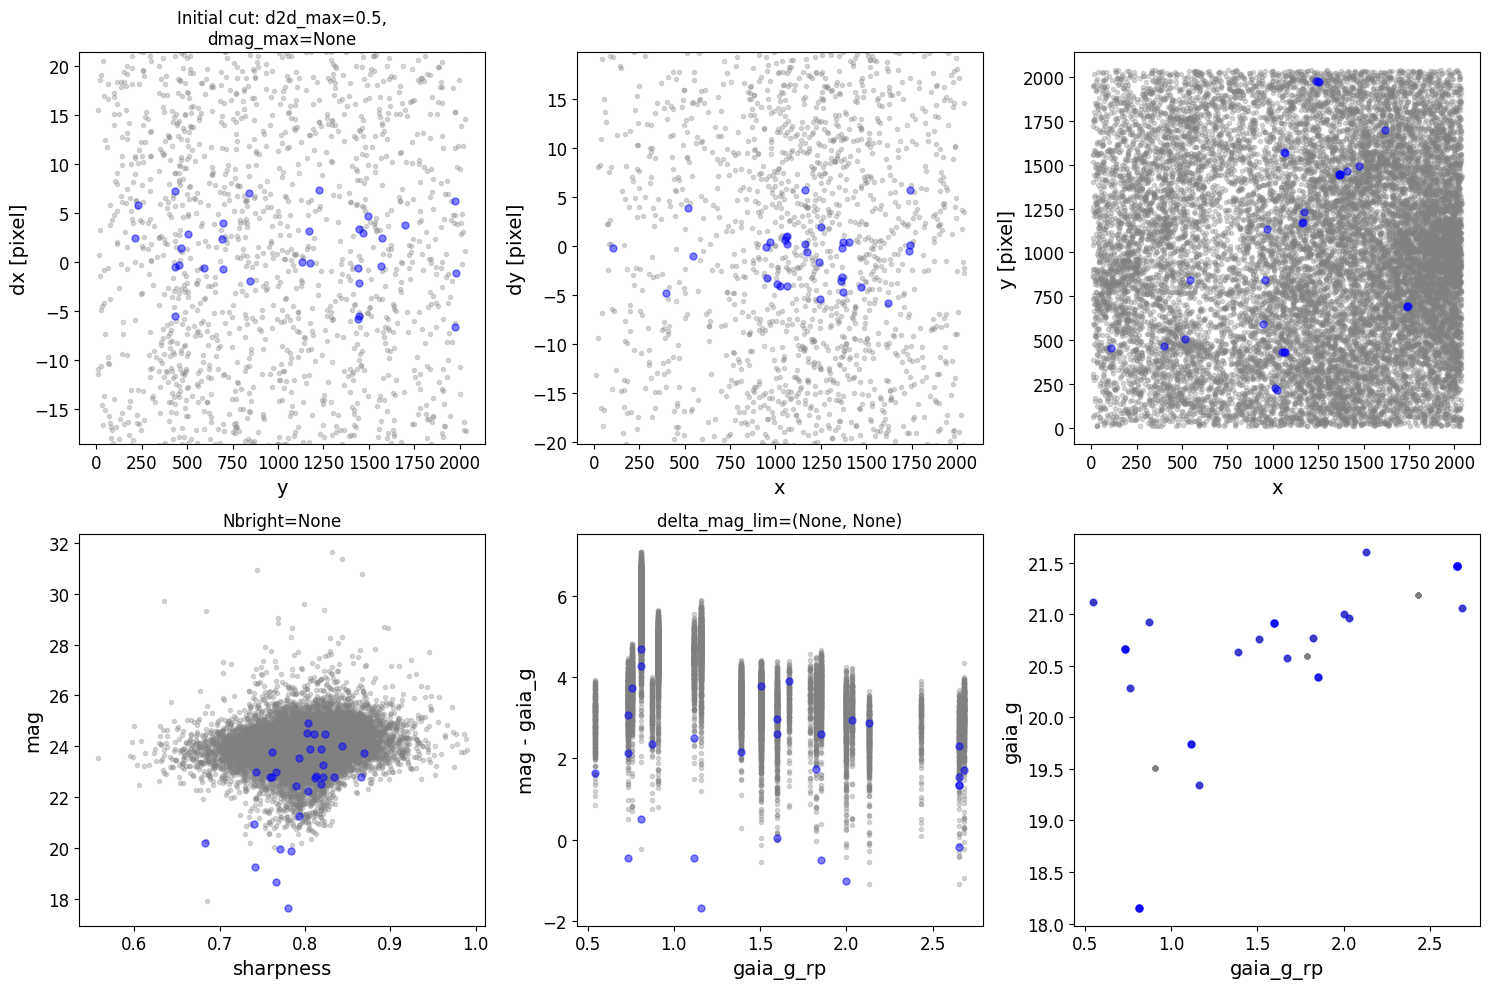

### Doing histogram cut for dx, slope_min:-0.019531 slope_max:0.019531 slope_stepsize:0.000195
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dx versus y
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=1.0, gaussian_sigma(bins)=0.2, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
   slope  intercept  maxval  index  d_bestguess  fwhm  multimax
0.000195       -0.2     8.0      7    -0.313411   2.0     False
BINWIDTH  2.657089778654378
Setting rough_cut_px=5.0. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp 0.48658902913772395

rough_cut_px=0.8 pixels removes 23 from 31 entries
Keeping 8 out of 8, skippin 0 because of null values in columns d_rot_tmp
median: -0.456752
75.000000 percentile cut: max residual for cut: 0.303977
__tmp_residuals 0.3039773274644234
median: -0.514837
i:00 mean:-0.514837(0.097462) stdev:0.217933(0.062912) X2norm:0

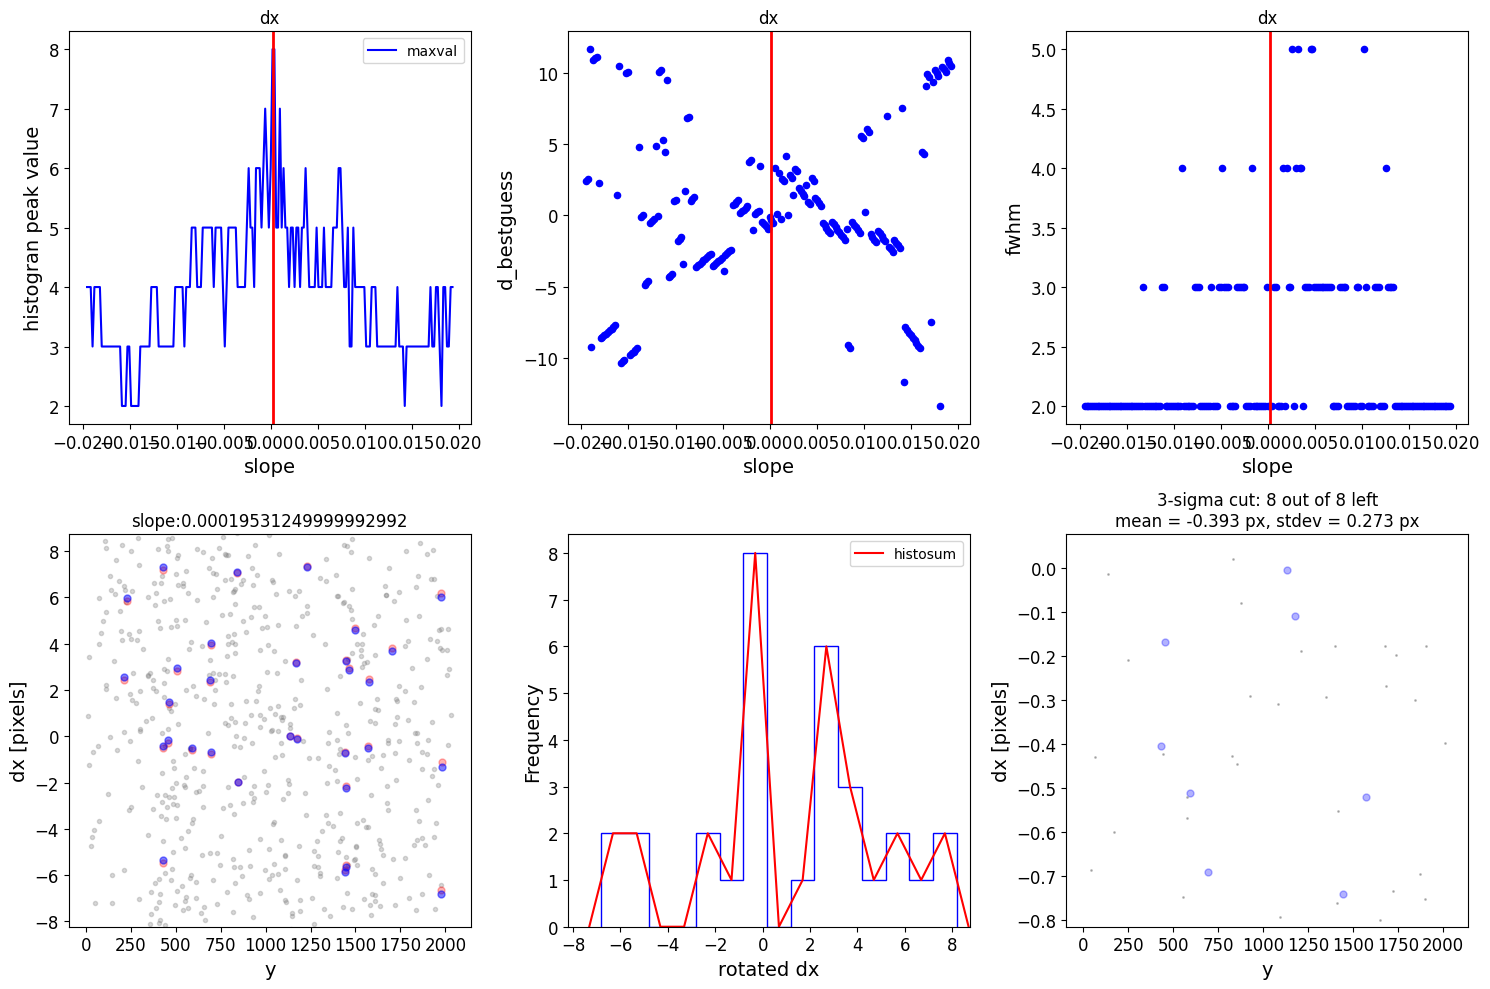

### Doing histogram cut for dy, slope_min:-0.019531 slope_max:0.019531 slope_stepsize:0.000195
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dy versus x
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=1.0, gaussian_sigma(bins)=0.2, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
    slope  intercept  maxval  index  d_bestguess  fwhm  multimax
-0.000195        0.2     7.0      1      0.12415   2.0     False
BINWIDTH  0.3745896783263082
Setting rough_cut_px=5.0. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp 0.9241496722301727

rough_cut_px=0.8 pixels removes 1 from 8 entries
Keeping 7 out of 7, skippin 0 because of null values in columns d_rot_tmp
median: 0.222512
75.000000 percentile cut: max residual for cut: 0.267235
__tmp_residuals 0.2672354700071692
median: 0.279016
i:00 mean:0.279016(0.098394) stdev:0.196787(0.062230) X2norm:0.88

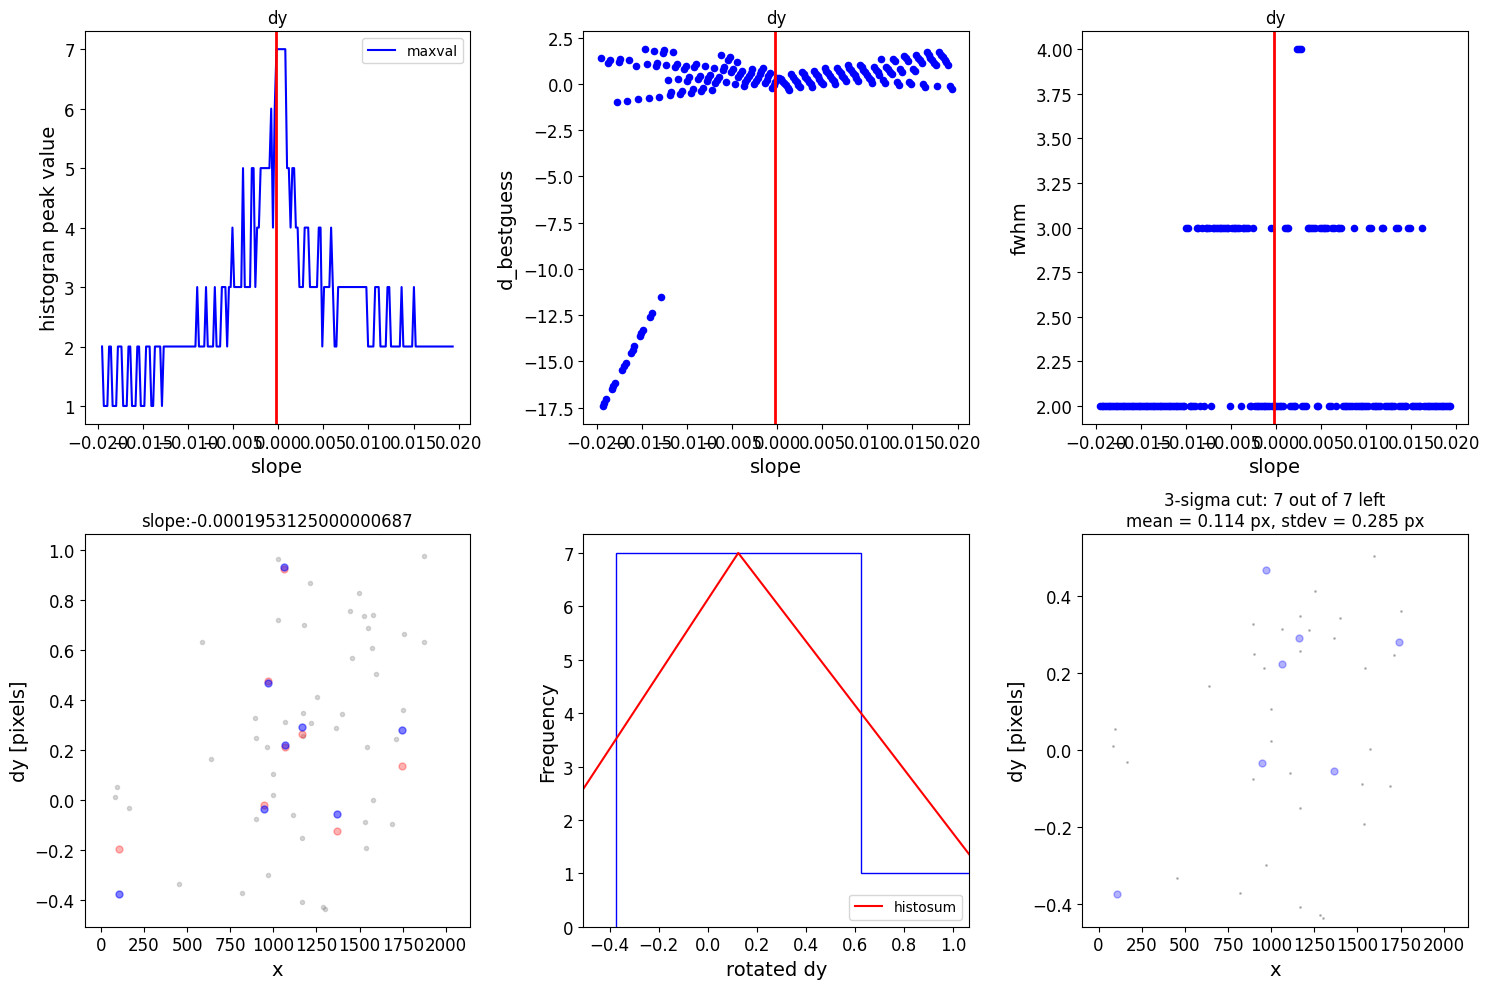

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

dx median of best matched objects of 1st iteration: -0.4128768956445583 dy median of best matched objects of 1st iteration: 0.13866698169738356
Matching reference catalog Gaia
Using 17049 image objects that are in x_idl=[-64.38,64.63] and y_idl=[-64.72,64.24] range
x 2008
y 2008
Keeping 23 out of 62 catalog objects within x=40.0-2008 and y=40.0-2008
Keeping 23  after removing NaNs from ra/dec
!! Matching 17049 image objects to 23 refcat objects!
########### !!!!!!!!!!  INITIAL CUT on matched cat: starting with 17049 objects
d2d =0.5 CUT using gaia_d2d:
gaia_d2d 0.5
31 left
31 of image photometry objects pass initial cuts #1, 17018 cut
### Doing histogram cut for dx, slope_min:-0.019531 slope_max:0.019531 slope_stepsize:0.000195
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dx versus y
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=1.0, gaussian_sigma(bins)=0.2, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
   slop

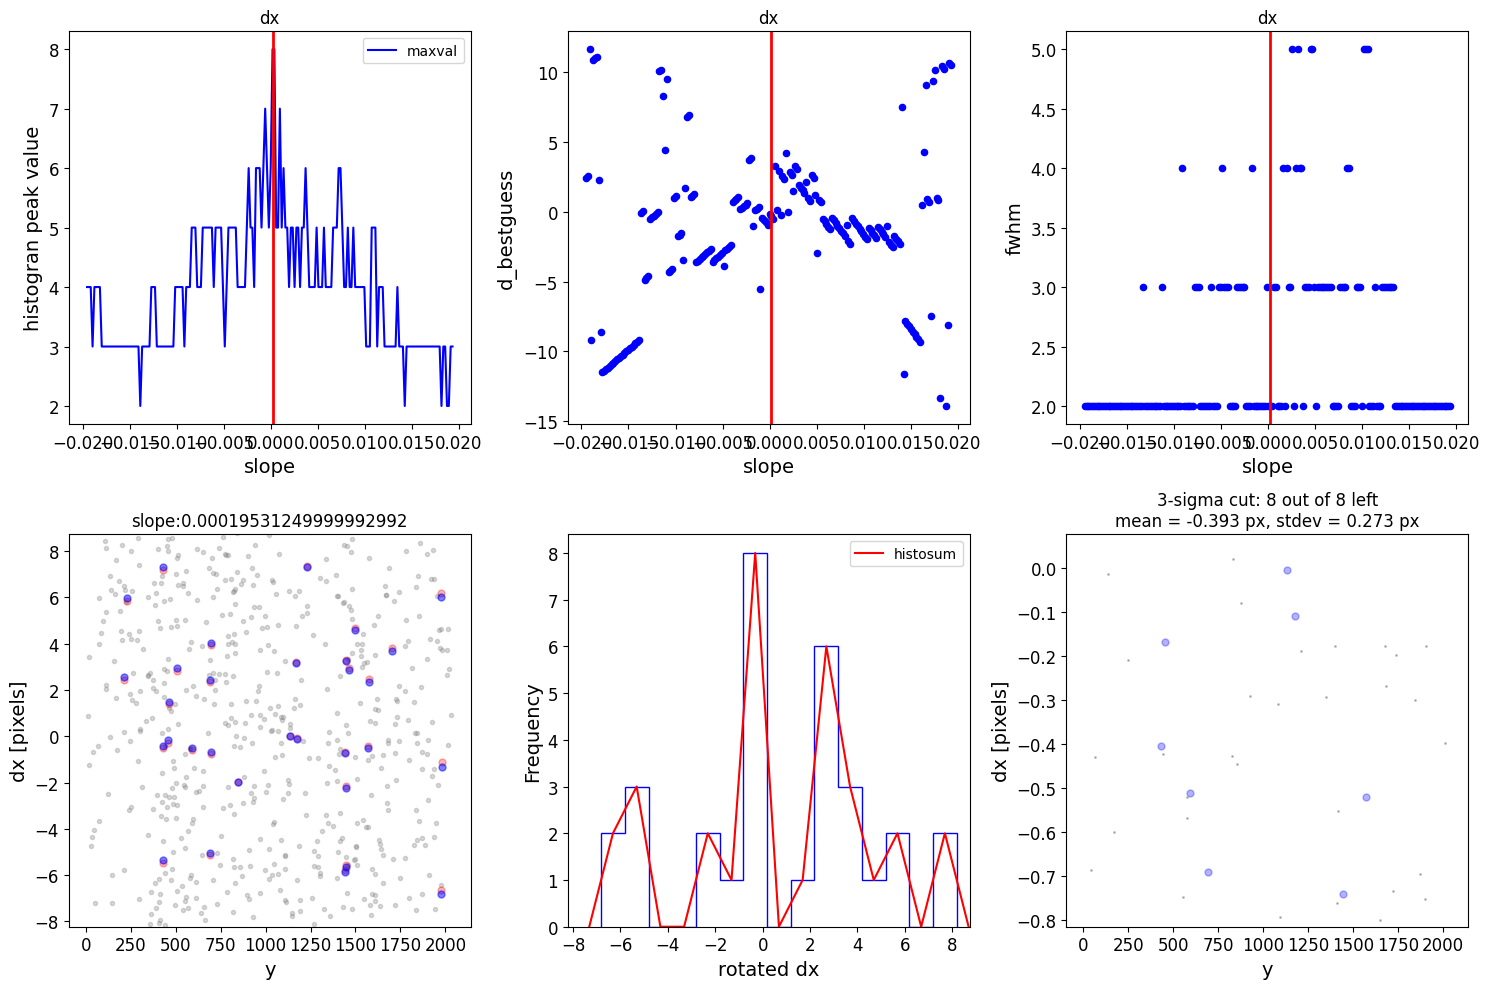

### Doing histogram cut for dy, slope_min:-0.019531 slope_max:0.019531 slope_stepsize:0.000195
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dy versus x
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=1.0, gaussian_sigma(bins)=0.2, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
    slope  intercept  maxval  index  d_bestguess  fwhm  multimax
-0.000195        0.2     7.0      1      0.12415   2.0     False
BINWIDTH  0.3745896783263082
Setting rough_cut_px=5.0. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp 0.9241496722301727

rough_cut_px=0.8 pixels removes 1 from 8 entries
Keeping 7 out of 7, skippin 0 because of null values in columns d_rot_tmp
median: 0.222512
75.000000 percentile cut: max residual for cut: 0.267235
__tmp_residuals 0.2672354700071692
median: 0.279016
i:00 mean:0.279016(0.098394) stdev:0.196787(0.062230) X2norm:0.88

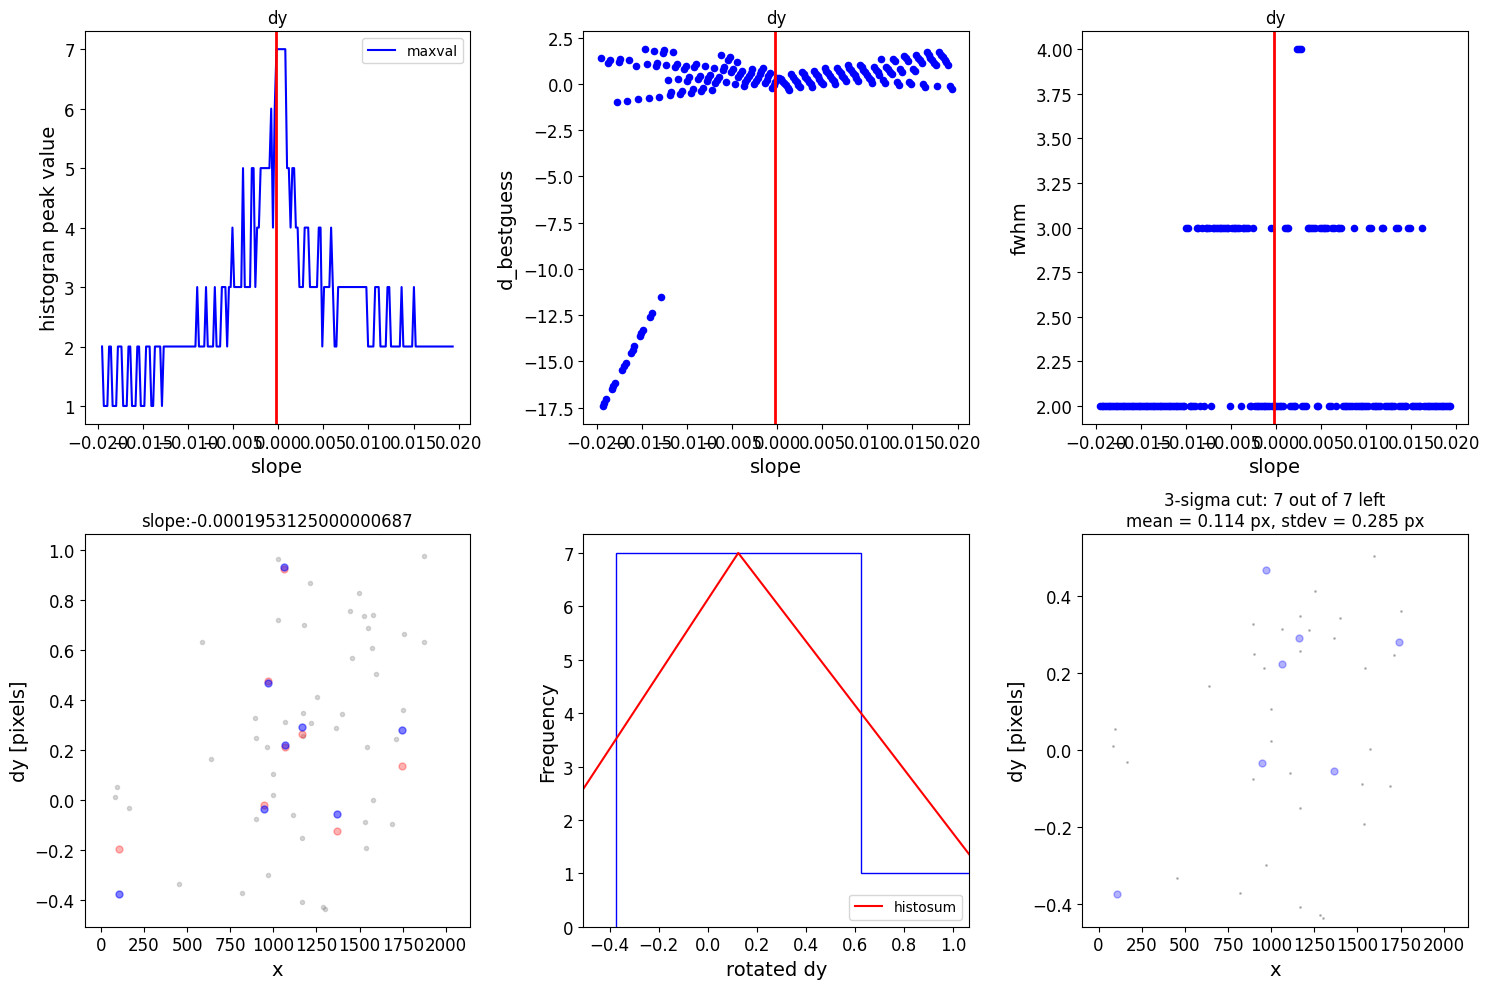

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-10-10 21:55:50,601 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.


Setting output directory for jw01783004005_02101_00001_nrcalong_jhat.fits file to ./jwstred_temp_gaia
7 matches are passed to tweakreg rshift fitting
Fitting tweakreg fitgeometry=rshift to xy=x,y to ra,dec=gaia_ra,gaia_dec


2024-10-10 21:55:51,075 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01783004005_02101_00001_nrcalong_cal.fits>],).
2024-10-10 21:55:51,080 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jwstred_temp_gaia/jw01783004005_02101_00001_nrcalong_jhat.fits
  output_dir: ./jwstred_temp_gaia
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_gaia: False
  gaia_catalog: GAIADR2
  min_gaia: 30
  save_gaia_catalog: False
  

replacing SIP ./jwstred_temp_gaia/jw01783004005_02101_00001_nrcalong_jhat.fits


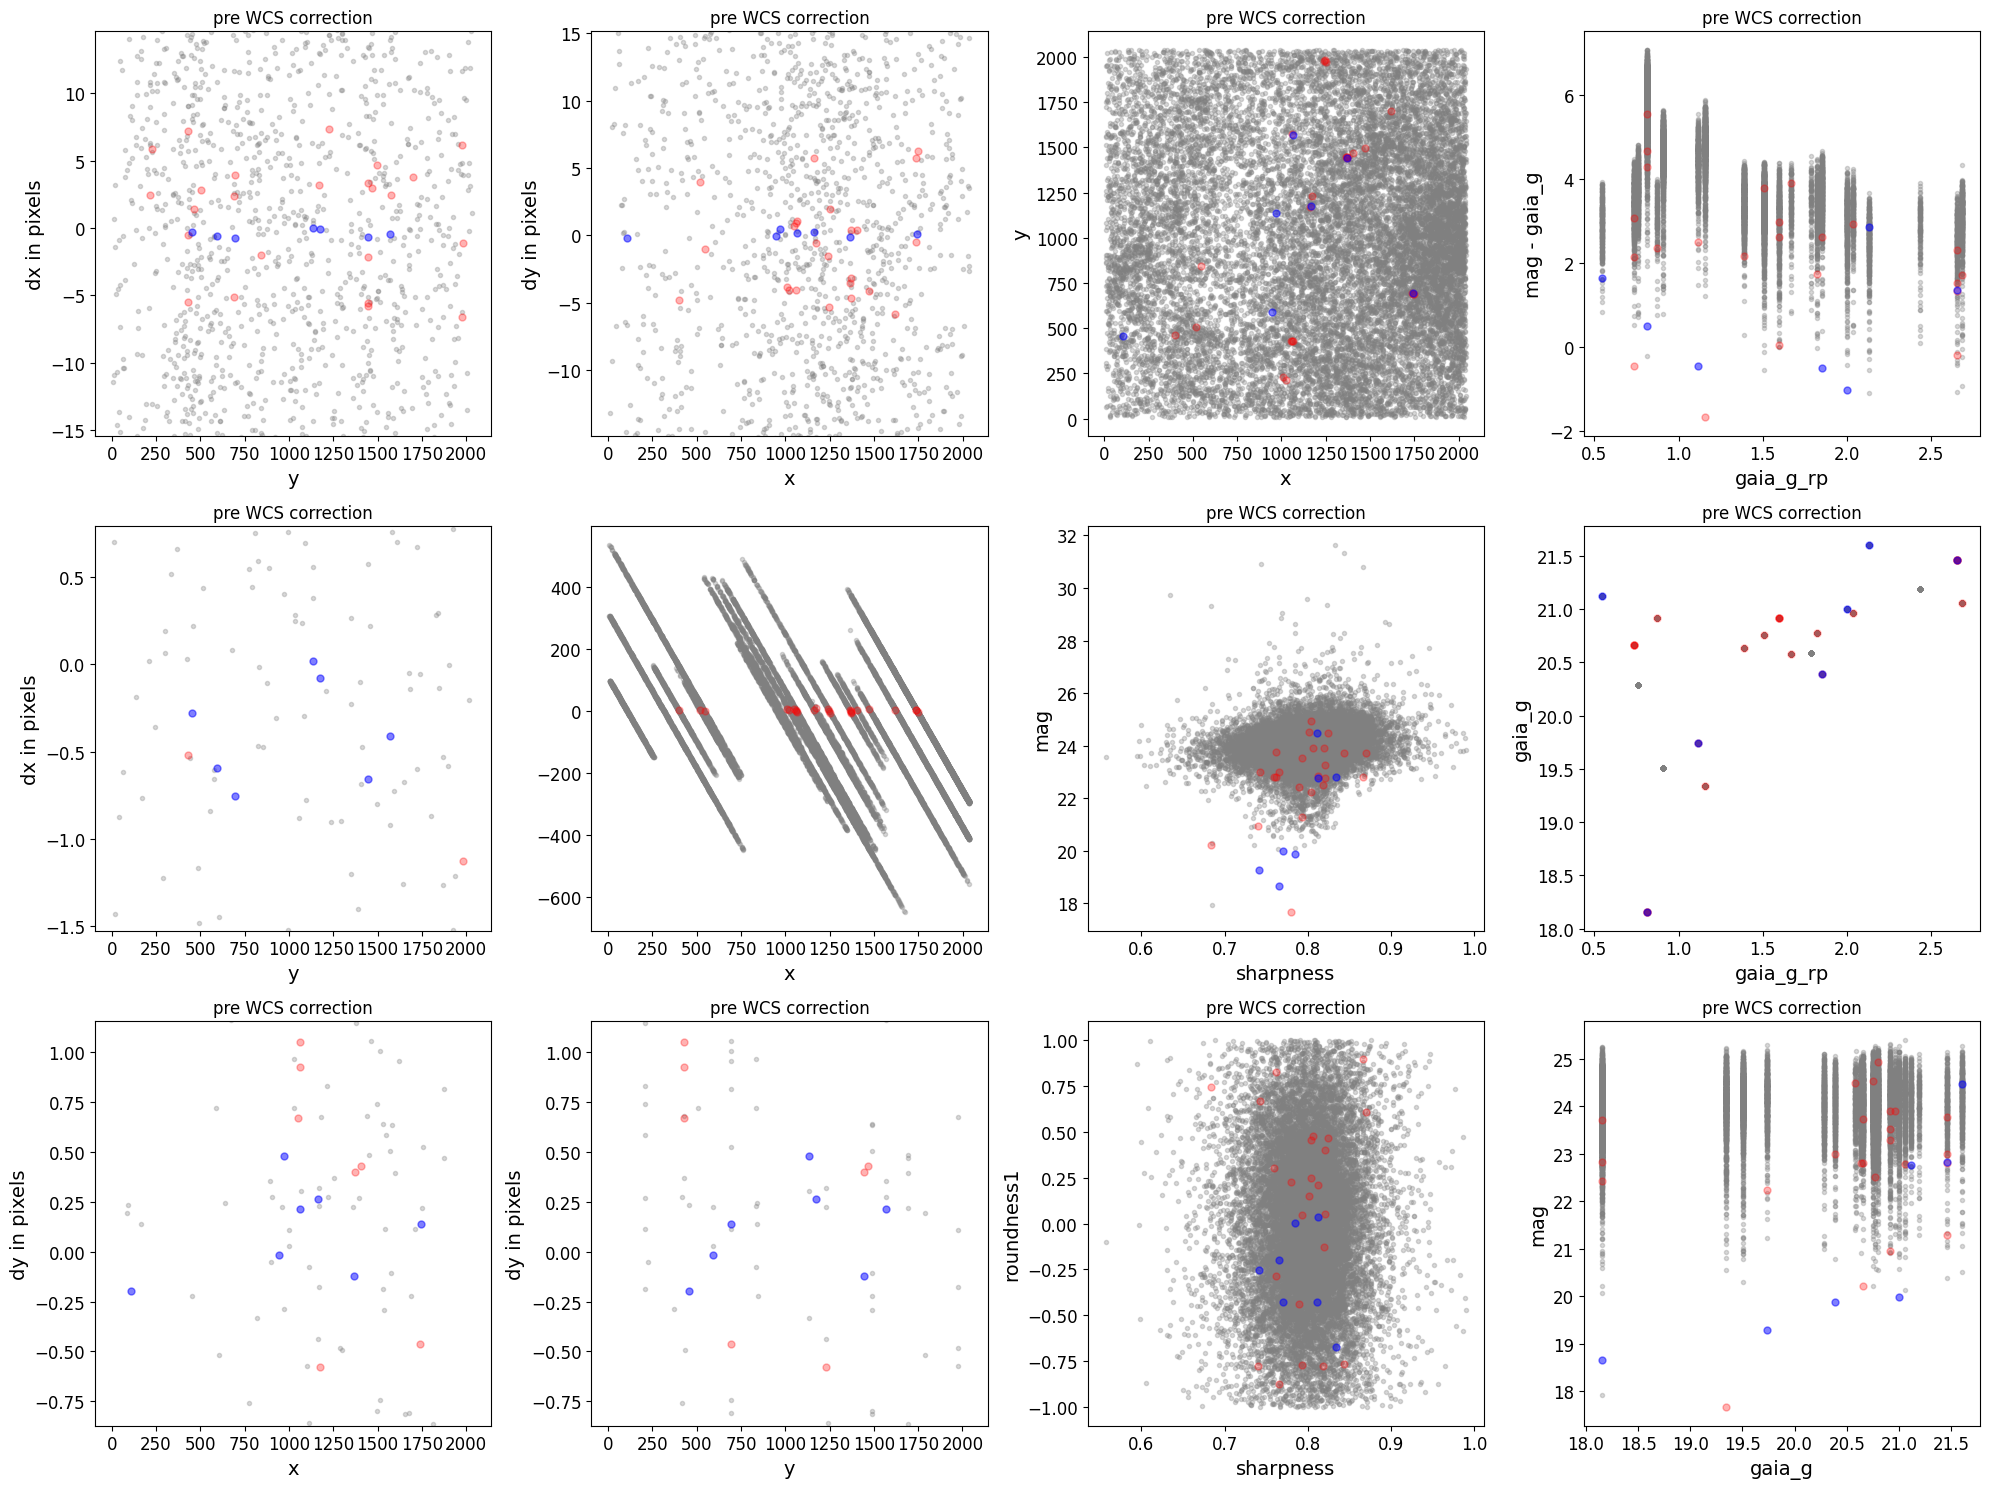

./jwstred_temp_gaia/jw01783004005_02101_00001_nrcalong_jhat.fits
Saving ./jwstred_temp_gaia/jw01783004005_02101_00001_nrcalong_jhat.good.phot.txt
Saving ./jwstred_temp_gaia/jw01783004005_02101_00001_nrcalong_jhat.all.phot.txt


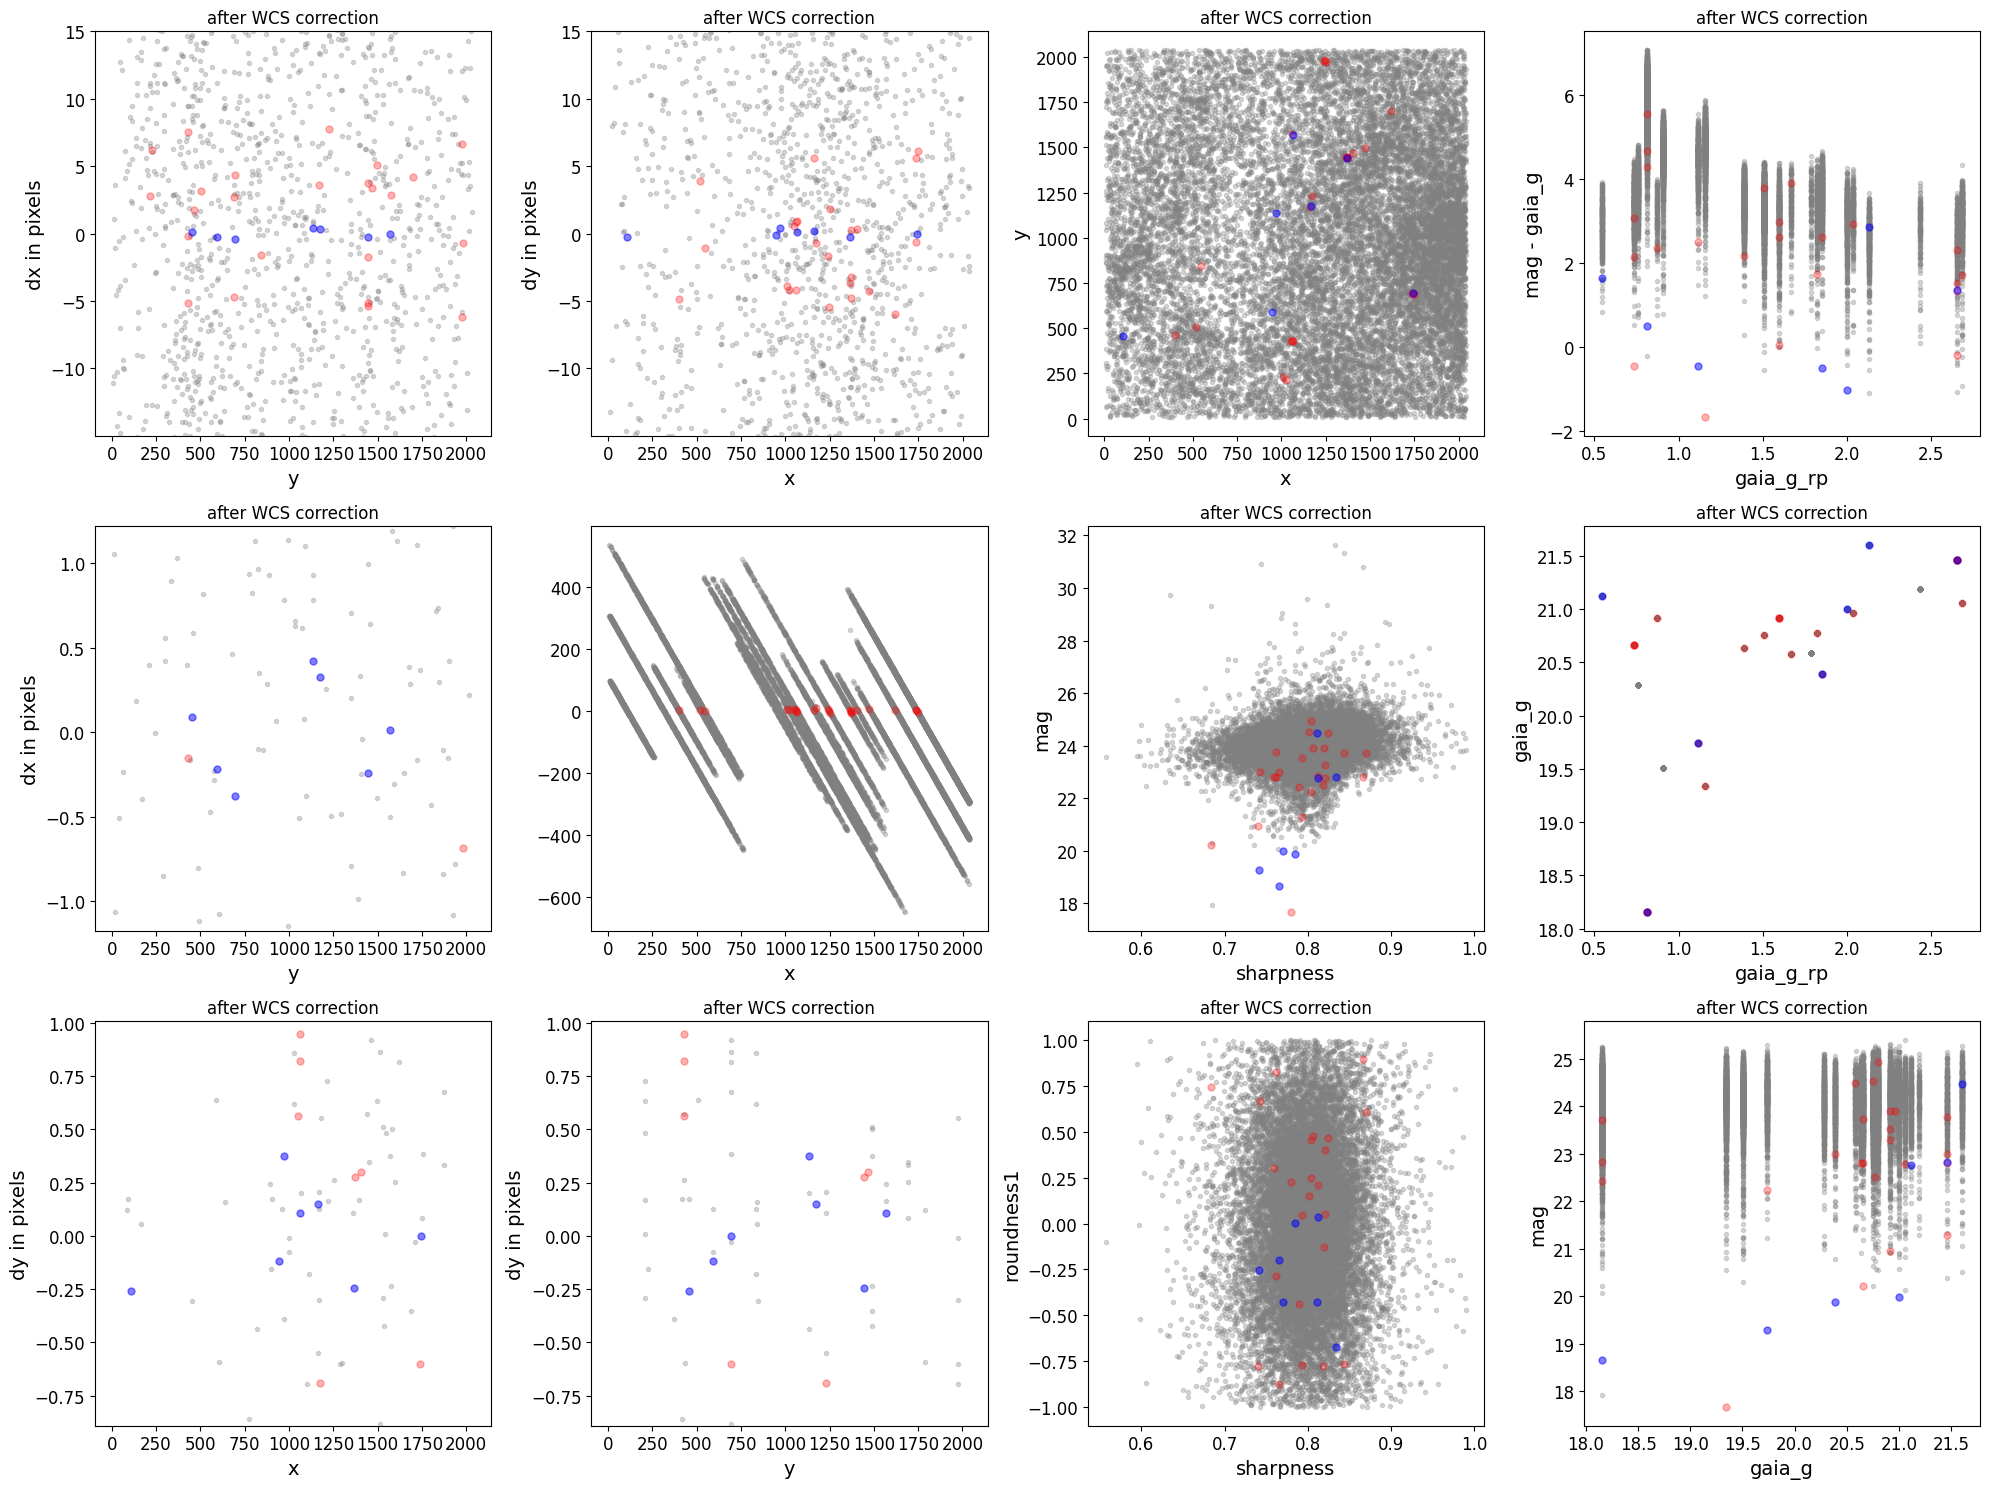

*** Note: close plots to continue!


0

In [26]:
wcs_align = st_wcs_align()
    
wcs_align.run_all(align_image,
		  telescope='jwst',
		  outsubdir='jwstred_temp_gaia',
          overwrite=True,
          d2d_max=0.5, 
          find_stars_threshold = 3,
          showplots=2,
          refcatname='Gaia',
          refcat_pmflag = True,
          histocut_order='dxdy',
#           use_dq = True,
          verbose = True,
          iterate_with_xyshifts = True,
#           xshift = -1,
#           yshift = 8,
#               sharpness_lim=(0.3,0.95),
#               roundness1_lim=(-0.7, 0.7),
#               Nbright = 1000,
              SNR_min= 5,
              dmag_max=.1,
#               objmag_lim =(15,22),
#               refmag_lim = (12,19),
              binsize_px = 1.0,
              saveplots = 0,
              slope_min = -40/2048,
              savephottable = 3)

#### Create ds9 region files

In [37]:
source_df = pd.read_csv('good_sources.csv')
np.savetxt('good_locs.txt', source_df[['x', 'y']].values, fmt = '%s')
np.savetxt('gaia_locs.txt', source_df[['gaia_x', 'gaia_y']].values, fmt = '%s')
np.savetxt('gaiaradec.txt', source_df[['gaia_ra', 'gaia_dec']].values, fmt = '%s')
np.savetxt('jwstradec.txt', source_df[['ra', 'dec']].values, fmt = '%s')

In [38]:
source_df.columns

Index(['aper_sum_2.3px', 'annulus_median_2.3px', 'aper_bkg_2.3px',
       'aper_sum_bkgsub_2.3px', 'flux_err_2.3px', 'mag', 'dmag', 'x', 'y',
       'sharpness', 'roundness1', 'roundness2', 'ra', 'dec', 'x_idl', 'y_idl',
       'gaia_ra', 'gaia_dec', 'gaia_ID', 'gaia_g', 'gaia_g_err', 'gaia_g_rp',
       'gaia_SOURCE_ID', 'gaia_ra_error', 'gaia_dec_error', 'gaia_rp',
       'gaia_rp_err', 'gaia_g_rp_err', 'delta_mag', '__weights', 'd_rot_tmp',
       '__tmp_residuals', 'gaia_x', 'gaia_y', 'dx', 'dy'],
      dtype='object')

(16.0, 25.0)

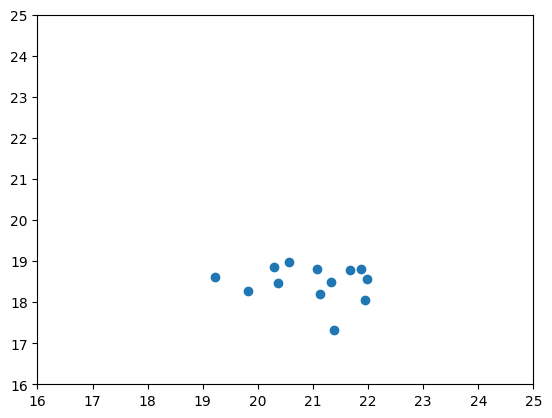

In [39]:
plt.scatter(source_df['mag'], source_df['gaia_g'])
plt.xlim(16, 25)
plt.ylim(16,25)

In [118]:
# to plot regions in ds9
try:
    align_df = pd.read_csv(align_image.replace('.fits', '.phot_psf.txt'), sep = '\s+')
    np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), align_df[['x', 'y']].values, fmt='%s')
except:
    align_df = pd.read_csv(align_image.replace('_cal.fits', '.phot.txt'), sep = '\s+')
    np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), align_df[['x', 'y']].values, fmt='%s')    

#### Gaia xmatch

In [27]:
from jwst.datamodels import ImageModel

In [28]:
im = fits.open(align_image)

hdr = im['SCI'].header
nx = hdr['NAXIS1']
ny = hdr['NAXIS2']

image_model = ImageModel(im)

ra0,dec0 = image_model.meta.wcs(nx/2.0-1,ny/2.0-1)
coord0 = SkyCoord(ra0,dec0,unit=(u.deg, u.deg), frame='icrs')
radius_deg = []
for x in [0,nx-1]:        
    for y in [0,ny-1]:     
        ra,dec = image_model.meta.wcs(x,y)
        radius_deg.append(coord0.separation(SkyCoord(ra,dec,unit=(u.deg, u.deg), frame='icrs')).deg)
radius_deg = np.amax(radius_deg)*1.1

In [29]:
dr = 'gaiadr3'

query ="SELECT * FROM {}.gaia_source WHERE CONTAINS(POINT('ICRS',\
        {}.gaia_source.ra,{}.gaia_source.dec),\
        CIRCLE('ICRS',{},{} ,{}))=1;".format(dr,dr,dr,ra0,dec0,radius_deg)

job5 = Gaia.launch_job_async(query)
tb_gaia = job5.get_results() 
print("Number of stars:",len(tb_gaia))

2024-10-10 22:00:33,212 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 39


In [30]:
tb_gaia

<Table length=39>
    solution_id             DESIGNATION          ... libname_gspphot
                                                 ...                
       int64                   object            ...      object    
------------------- ---------------------------- ... ---------------
1636148068921376768 Gaia DR3 2589380570953825920 ...                
1636148068921376768 Gaia DR3 2589380601019524480 ...           MARCS
1636148068921376768 Gaia DR3 2589380605313829120 ...                
1636148068921376768 Gaia DR3 2589380635379263360 ...                
1636148068921376768 Gaia DR3 2589380639673564544 ...                
1636148068921376768 Gaia DR3 2589380639673564672 ...                
1636148068921376768 Gaia DR3 2589380639673817728 ...                
1636148068921376768 Gaia DR3 2589380639673818112 ...           MARCS
1636148068921376768 Gaia DR3 2589380639673818368 ...           MARCS
                ...                          ... ...             ...
1636148068921376768 Gaia DR3 2589389470126671872 ...                
1636148068921376768 Gaia DR3 2589389504486064640 ...                
1636148068921376768 Gaia DR3 2589389504486067584 ...                
1636148068921376768 Gaia DR3 2589389504486113664 ...                
1636148068921376768 Gaia DR3 2589389504486552960 ...                
1636148068921376768 Gaia DR3 2589389534551502464 ...                
1636148068921376768 Gaia DR3 2589389573205544448 ...                
1636148068921376768 Gaia DR3 2589389573205591552 ...                
1636148068921376768 Gaia DR3 2589389573206033536 ...

In [31]:
np.array(tb_gaia[['ra', 'dec']])
# np.savetxt('all_gaia_locs.txt', np.array(tb_gaia[['ra', 'dec']]), fmt = '%s')

array([(24.18323475, 15.77876858), (24.15986414, 15.77304302),
       (24.1526187 , 15.77598685), (24.17101887, 15.78250192),
       (24.17066312, 15.77894125), (24.16752378, 15.77817367),
       (24.1739396 , 15.78363996), (24.17475518, 15.78017529),
       (24.16973453, 15.77699177), (24.15164841, 15.77676932),
       (24.15712271, 15.79461946), (24.15922705, 15.78486668),
       (24.16151031, 15.78864196), (24.16140496, 15.78991223),
       (24.16437024, 15.79589024), (24.16324562, 15.7954319 ),
       (24.16363386, 15.79526386), (24.16146294, 15.7907579 ),
       (24.15180071, 15.78882457), (24.14788654, 15.80481235),
       (24.13919894, 15.8066255 ), (24.14058767, 15.80597137),
       (24.1767161 , 15.79016792), (24.19507192, 15.79775489),
       (24.18856765, 15.79663143), (24.17593574, 15.80300281),
       (24.17632963, 15.80470166), (24.17547218, 15.80456762),
       (24.17240164, 15.8036312 ), (24.16846519, 15.80155078),
       (24.16357553, 15.79926182), (24.1793781 , 15.805

In [69]:
jhat_df = pd.read_csv(glob.glob(align_image.replace('_cal.fits', '.phot.txt'))[0], sep = '\s+') #useful
# jhat_df[['x', 'y']].to_csv('region.csv', header = None, index = False)

In [70]:
jh_ra, jh_dec = jhat_df['ra'].to_numpy()*u.degree, jhat_df['dec'].to_numpy()*u.degree
jh_skycoord = SkyCoord(ra = jh_ra, dec = jh_dec)
ga_ra, ga_dec = np.array(tb_gaia['ra'])*u.degree, np.array(tb_gaia['dec'])*u.degree
ga_skycoord = SkyCoord(ra = ga_ra, dec = ga_dec)

In [71]:
dist_matched_df = xmatch_common(jh_skycoord, ga_skycoord, dist_limit=1)

Text(0.5, 1.0, 'jwst/gaia xmatch')

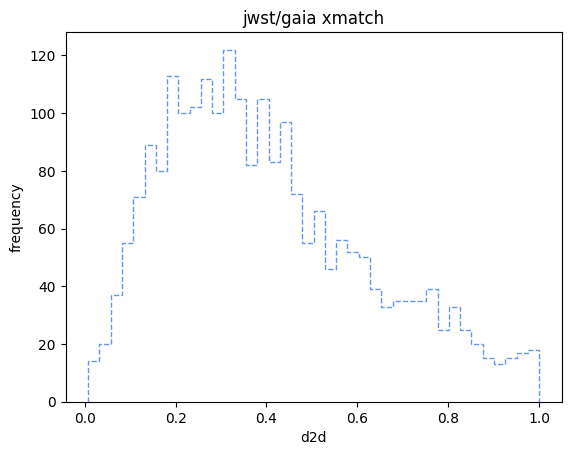

In [72]:
_ = plt.hist(dist_matched_df['d2d'], bins = 40, histtype = 'step', 
             linestyle = '--', color = 'cornflowerblue')
plt.xlabel('d2d')
plt.ylabel('frequency')
plt.title('jwst/gaia xmatch')

In [73]:
# np.median(dist_matched_df['d2d'])
np.sqrt(np.mean(dist_matched_df['d2d']**2))

0.46069552977842515

In [74]:
len(dist_matched_df)

2281

In [93]:
jwst_phot = jwst_photclass()
phot_img = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal.fits')[0]
jwst_phot.run_phot(imagename=phot_img,
                   photfilename='jwstred_temp_gaia/jhat_corr_phot.txt',
                   overwrite=True,
                   ee_radius=70,
                   use_dq=True,
                   SNR_min = 10,
                   find_stars_threshold = 5)
# ref_catname = ref_image.replace('.fits','.phot.txt') # the default
refcat = Table.read('jwstred_temp_gaia/jhat_corr_phot.txt',format='ascii')
print(refcat)

0 jwstred_temp_gaia/jhat_corr_phot.txt
Using DQ extension!!


2024-10-10 16:53:40,389 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-10-10 16:53:40,755 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-10-10 16:53:40,765 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-10-10 16:53:40,766 - stpipe - INFO - Instrument: NIRCAM
2024-10-10 16:53:40,767 - stpipe - INFO - Detector: NRCBLONG
2024-10-10 16:53:40,767 - stpipe - INFO - Filter: F277W
2024-10-10 16:53:40,768 - stpipe - INFO - Pupil: CLEAR
2024-10-10 16:53:40,768 - stpipe - INFO - Subarray: FULL
2024-10-10 16:53:40,791 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.1086
aper_sum_2.3px annulus_median_2.3px aper_bkg_2.3px ...   x_idl      y_idl   
-------------- -------------------- -------------- ... ---------- ----------
     16.351844             0.333756       5.599881 ... -62.064349 -64.800427
    607.555385             1.284424      21.550551 ... -46.809357 -64.789169
      8.952579             0.307766       5.163813 ... -34.075123 -64.850759
    282.103533              0.65342      10.963331 ... -27.150068 -64.847817
    208.035467             0.610967      10.251023 ... -11.876649 -64.756093
     43.248325              0.35947       6.031314 ... -10.540383 -64.721455
     12.444766             0.423903       7.112399 ...  -7.082972 -64.778047
      7.563831             0.168635       2.829423 ...   3.189919 -64.705572
      11.57337             0.196435       3.295852 ...  17.417172 -64.595043
      6.548051             0.156673       2.628716 ...  35.904837 -64.438856
           ...                  ...            ... ...        ..

In [88]:
jh_ra, jh_dec = np.array(refcat['ra'])*u.degree, np.array(refcat['dec'])*u.degree
jh_skycoord = SkyCoord(ra = jh_ra, dec = jh_dec)
ga_ra, ga_dec = np.array(tb_gaia['ra'])*u.degree, np.array(tb_gaia['dec'])*u.degree
ga_skycoord = SkyCoord(ra = ga_ra, dec = ga_dec)

In [89]:
dist_matched_df = xmatch_common(jh_skycoord, ga_skycoord, dist_limit=1)

Text(0.5, 1.0, 'jwst/gaia xmatch')

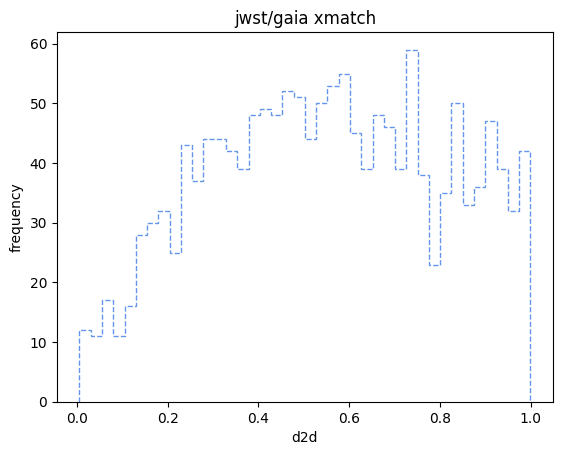

In [90]:
_ = plt.hist(dist_matched_df['d2d'], bins = 40, histtype = 'step', 
             linestyle = '--', color = 'cornflowerblue')
plt.xlabel('d2d')
plt.ylabel('frequency')
plt.title('jwst/gaia xmatch')

In [91]:
len(dist_matched_df)

1532

In [32]:
# np.savetxt('corrected_coords.txt', refcat[['ra', 'dec']].to_pandas().values, fmt='%s')    
np.savetxt('corrected_coords_gaia.txt', tb_gaia[['ra', 'dec']].to_pandas().values, fmt='%s')    

In [92]:
np.sqrt(np.median(dist_matched_df['d2d']**2))

0.5483346694129787

#### Breakup star mask

In [6]:
jwst_im = fits.open(glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal_og.fits')[0])

In [7]:
jwst_im.info()

Filename: jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal_og.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     346   ()      
  1  SCI           1 ImageHDU       156   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [26608B]   


In [5]:
dq_mask = deepcopy(jwst_im['DQ'].data)

In [6]:
flag_sat = np.array(dq_mask != 1) & np.array(dq_mask != 2) & np.array(dq_mask != 3)

In [7]:
np.shape(flag_sat), np.shape(dq_mask)

((2048, 2048), (2048, 2048))

In [8]:
flag_sat.sum()

4165548

In [9]:
dq_mask[flag_sat] = 10
dq_mask[~flag_sat] = 1

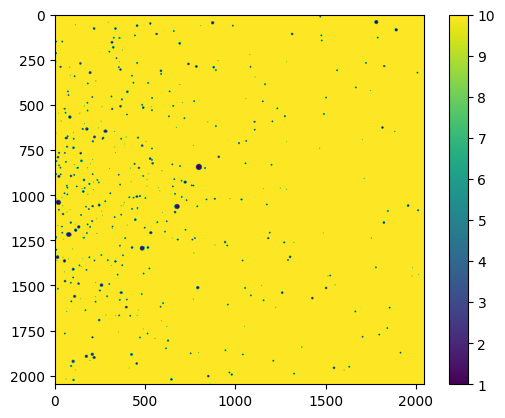

In [10]:
plt.imshow(dq_mask)
plt.colorbar()

In [11]:
np.unique(dq_mask)

array([ 1, 10], dtype=uint32)

In [12]:
def expand_mask(mask, size = 40):
    # Create a binary mask where pixels with flag 1 are set to True
    binary_mask = (mask == 1)
#     binary_mask = np.array(mask == 1) | np.array(mask == 2) | np.array(mask == 3)
    
    # Define a structuring element
    structuring_element = np.ones((size, size), dtype=bool)
    
    # Perform binary dilation
    expanded_mask = binary_dilation(binary_mask, structure=structuring_element)
    
    # Convert the expanded binary mask back to the original mask format
    mask_exp = np.where(expanded_mask, 1, mask)
    
    return mask_exp

In [16]:
expmask = expand_mask(dq_mask)
# expmask[expmask == 1] = False
expmask[expmask == 10] = False
expmask[expmask == 1] = True

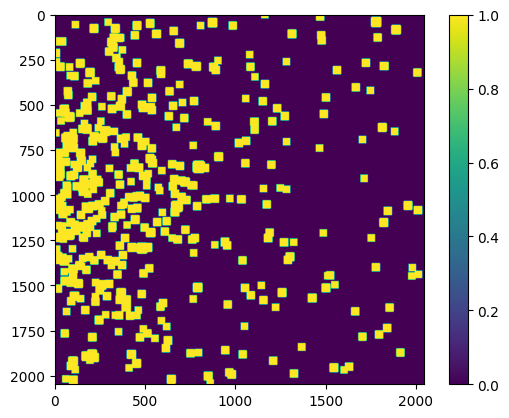

In [17]:
# expmask[expmask > 10] = 10
plt.imshow(expmask)
plt.colorbar()

In [18]:
expmask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

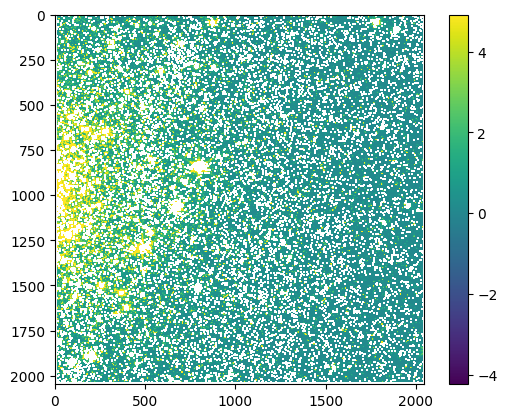

In [35]:
plt.imshow(jwst_im['SCI'].data, vmin = np.nanmedian(jwst_im['SCI'].data) - 1*np.nanstd(jwst_im['SCI'].data),
                                vmax = np.nanmedian(jwst_im['SCI'].data) + 1*np.nanstd(jwst_im['SCI'].data))
plt.colorbar()

In [307]:
# masked_im = np.where(dq_mask, jwst_im['SCI'].data, 3)
masked_im = np.where(expmask, jwst_im['SCI'].data, np.nan)

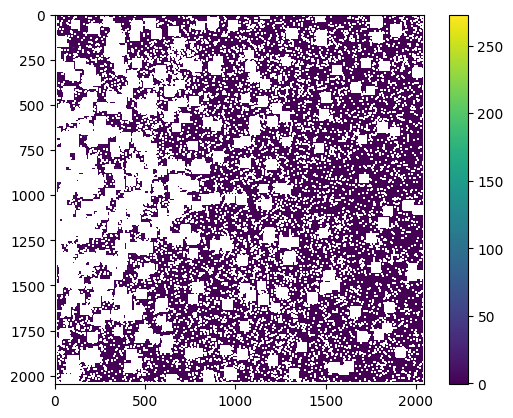

In [308]:
plt.imshow(masked_im)
plt.colorbar()

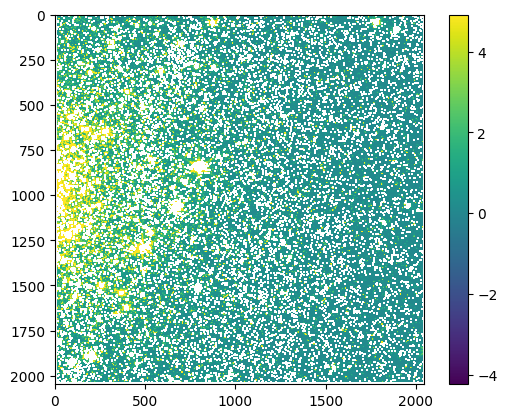

In [38]:
plt.imshow(masked_im, vmin = np.nanmedian(masked_im) - 1*np.nanstd(masked_im),
                      vmax = np.nanmedian(masked_im) + 1*np.nanstd(masked_im))
plt.colorbar()

In [309]:
jwst_im['SCI'].data = masked_im

In [19]:
# bin_dq_hdu = 
data, hdr = fits.getdata('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal_og.fits', ext=3, header=True)
# bin_dq_data = np.where(expmask, jwst_im['DQ'].data, 3)
hdr['extname'] = 'BIN_DQ'
image_hdu = fits.ImageHDU(data=expmask, name="BIN_DQ", header = hdr)
jwst_im.insert(8, image_hdu)
# bin_dq_hdu

In [20]:
jwst_im.info()

Filename: jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal_og.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     346   ()      
  1  SCI           1 ImageHDU       156   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   uint32   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  BIN_DQ        1 ImageHDU        11   (2048, 2048)   uint32   
  9  ASDF          1 BinTableHDU     11   1R x 1C   [26608B]   


In [21]:
jwst_im.writeto('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal_masked.fits', overwrite = True)

In [ ]:
def prepare_image(data_original, imhdr, area=None, dq=None, 
                  DNunits=False, dq_ignore_bits = 4):
    # dq_ignore_bits contains the bits in the dq which are still ok, so they
    # should be ignored.
    # 2 = Pixel saturated during integration
    # 4 = Jump detected during integration

    if area is not None:

        if self.verbose: print('Applying Pixel Area Map')

        data_pam = data_original * area

    else:

        data_pam = data_original

    if DNunits:
        if imhdr["BUNIT"]!='MJy/sr':
            raise RuntimeError(f'imhdr["BUNIT"]={imhdr["BUNIT"]} is not MJy/sr!')
        if self.verbose: print(f'Converting units from {imhdr["BUNIT"]} to DN/s')
        data = data_pam / imhdr['PHOTMJSR']
    else:
        data = data_pam


    if dq is not None:
        # dq_ignore_bits are removed from the mask!
        #fits.writeto('TEST_dq_delme.fits',dq,overwrite=True,output_verify='ignore')
        mask = np.bitwise_and(dq,np.full(data_original.shape, ~dq_ignore_bits, dtype='int'))
    else:
        mask = np.zeros(data_original.shape, dtype='int')

    # hijack a few bits for our purposes...
    mask[np.isnan(data)==True] = 8
    mask[np.isfinite(data)==False] = 8
    mask[np.where(data==0)] = 16

    #fits.writeto('TEST_mask_delme.fits',mask,overwrite=True,output_verify='ignore')

    data[mask>0] = np.nan

    return data,mask,DNunits

In [19]:
test_im = fits.open('jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal.fits')

In [20]:
test_im.info()

Filename: jwstred_temp_gaia/jw01334001001_02101_00002_nrcblong_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     346   ()      
  1  SCI           1 ImageHDU       156   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  BIN_DQ        1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  9  ASDF          1 BinTableHDU     11   1R x 1C   [26608B]   


In [23]:
data_original, imhdr = test_im['SCI'].data, test_im['SCI'].header
area = test_im['AREA'].data
dq = test_im['BIN_DQ'].data
dq_ignore_bits = 4
DNunits = False

if area is not None:

#     if self.verbose: print('Applying Pixel Area Map')

    data_pam = data_original * area

else:

    data_pam = data_original

if DNunits:
    if imhdr["BUNIT"]!='MJy/sr':
        print('no')
#         raise RuntimeError(f'imhdr["BUNIT"]={imhdr["BUNIT"]} is not MJy/sr!')
#     if self.verbose: print(f'Converting units from {imhdr["BUNIT"]} to DN/s')
    data = data_pam / imhdr['PHOTMJSR']
else:
    data = data_pam


if dq is not None:
    # dq_ignore_bits are removed from the mask!
    #fits.writeto('TEST_dq_delme.fits',dq,overwrite=True,output_verify='ignore')
    mask = np.bitwise_and(dq,np.full(data_original.shape, ~dq_ignore_bits, dtype='int'))
else:
    mask = np.zeros(data_original.shape, dtype='int')

# hijack a few bits for our purposes...
mask[np.isnan(data)==True] = 8
mask[np.isfinite(data)==False] = 8
mask[np.where(data==0)] = 16

#fits.writeto('TEST_mask_delme.fits',mask,overwrite=True,output_verify='ignore')

data[mask>0] = np.nan

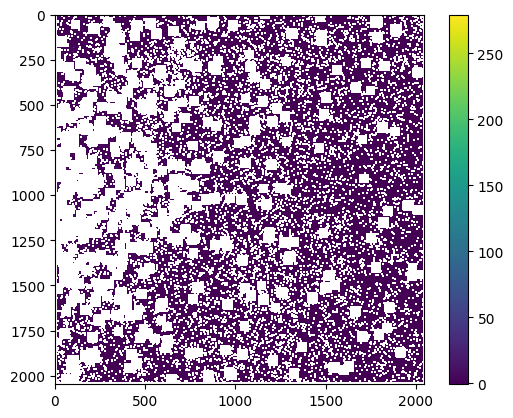

In [24]:
plt.imshow(data)
plt.colorbar()

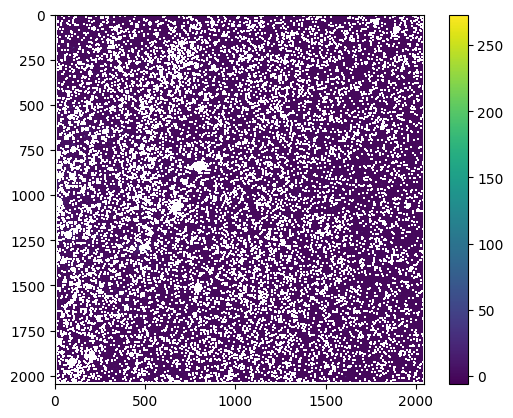

In [15]:
plt.imshow(test_im['SCI'].data)
plt.colorbar()

In [275]:
dq = test_im['BIN_DQ'].data
og_data = np.array(test_im['SCI'].data)
dq_ignore_bits = 4
mask = np.bitwise_and(dq, np.full(og_data.shape, ~dq_ignore_bits, dtype = 'int'))

In [247]:
dq

array([[2151153665, 2151153665, 2151153665, ..., 2151153665, 2151153665,
        2151153665],
       [2151153665, 2151153665, 2151153665, ..., 2151153665, 2151153665,
        2151153665],
       [2151153665, 2151153665, 2151153665, ..., 2151153665, 2151153665,
        2151153665],
       ...,
       [2155347969, 2151153665, 2151153665, ..., 2151153665, 2151153665,
        2151153665],
       [2151153665, 2151153665, 2151153665, ..., 2151153665, 2151153665,
        2151153665],
       [2151153665, 2151153665, 2151153665, ..., 2151153665, 2151153665,
        2151153665]], dtype=uint32)

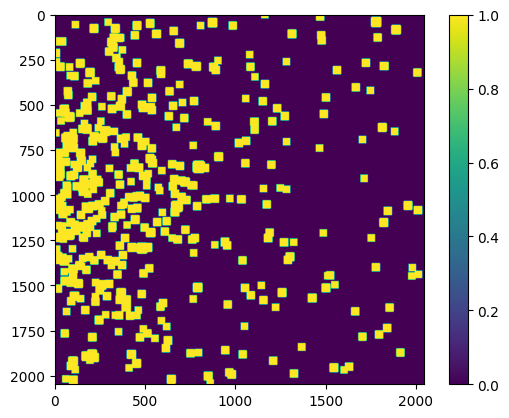

In [276]:
# mask = np.array(mask, dtype = 'float32')
# mask[mask>0] = np.nan
plt.imshow(mask)
plt.colorbar()

In [148]:
np.bitwise_and(np.array([1]), np.array([5]))

array([1])

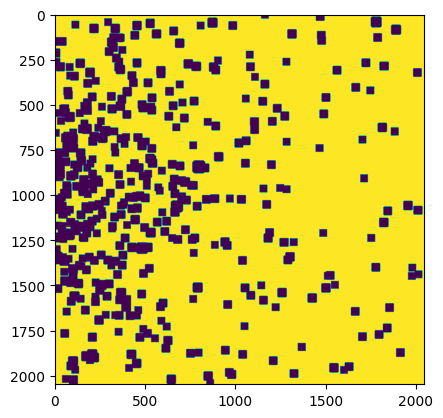

In [142]:
plt.imshow(dq)